In [2]:
#TODO
# Simplify calculate area, compare_outline_complexity, and find_max_area_bias to read in evolving_lakes_gdf
# Change compare_outline_complexity to use geodesic area
# Use calculate_area function in lake_locations or FigS1_lake_reexamination_methods notebook?

Code to Figs. 2, 3, 4 of Sauthoff and others, 2024, *Journal*

This code requires a XX GB server or local memory

Written 2023-11-11 by W. Sauthoff (wsauthoff.github.io)

# Set up computing environment

In [3]:
# Import libraries
import datetime
# import earthaccess
import fiona
import geopandas as gpd
import glob
from IPython.display import clear_output
from math import radians
import matplotlib
# import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.legend_handler import HandlerPatch, HandlerTuple
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os
# from os import path
import pandas as pd
from pyproj import CRS, Geod, Transformer
import rioxarray
# from rioxarray.exceptions import NoDataInBounds
from shapely.geometry import MultiPolygon, Point, Polygon
from shapely.ops import unary_union
# from skimage import measure
# import xarray as xr

# Magic functions
%matplotlib widget

# from IPython.display import Audio, display
# def play_sound():
#     display(Audio(url="http://codeskulptor-demos.commondatastorage.googleapis.com/pang/pop.mp3", autoplay=True))

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    OUTPUT_DIR = '/home/jovyan/1_evolving_lakes/output/Figs234_lake_reexamination_results/'
    OUTPUT_DIR_GIT = '/home/jovyan/1_evolving_lakes/Sauthoff-202X-evolving-lakes/output'

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031" # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer
geod = Geod(ellps="WGS84") # Create a Geod object for calculating area on the WGS84 ellipsoid

# Define utility functions
def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    x, y = ll2ps(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

# # Change default font to increase font size
# plt.rcParams.update({'font.size': 8})

# Functions

In [4]:
# def timestamp_to_fractional_year(timestamp):
#     # Check if the year is a leap year
#     year = timestamp.year
#     if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
#         days_in_year = 366
#     else:
#         days_in_year = 365

#     # Calculate the day of the year
#     day_of_year = timestamp.timetuple().tm_yday

#     # Calculate the fractional year
#     fractional_year = year + (day_of_year - 1) / days_in_year
    
#     return fractional_year

# # # Example usage
# # timestamp = pd.Timestamp('2023-03-07 12:34:56')
# # fractional_year = timestamp_to_fractional_year(timestamp)
# # print(f"Fractional Year: {fractional_year}")

In [5]:
def compare_outline_complexity(lake_gdf):
    '''
    Calculate the perimeter-to-area ratio for a given lake in both the stationary outline and the 
    unary union of evovling outlines
    '''
    lake_name = lake_gdf['name'].iloc[0]
    stationary_outline = lake_gdf['geometry'].iloc[0]

    # Attempt to open evolving outlines geojson
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except Exception as e:  # Using a general exception to catch all file and driver errors
        print(f"File for {lake_name} not found or error reading file: {e}")
        return None

    # Create evolving outlines unary union
    evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))

    # Calculating complexity - perimeter-to-area ratio
    stationary_complexity = stationary_outline.length / stationary_outline.area
    evolving_complexity = evolving_outlines_unary_union.length / evolving_outlines_unary_union.area
    complexity_ratio = evolving_complexity / stationary_complexity
    
    return {
        'lake_name': lake_name,
        'stationary_complexity': stationary_complexity,
        'evolving_complexity': evolving_complexity,
        'complexity_ratio': complexity_ratio
    }

In [6]:
def shoreline_development_factor(lake_gdf):
    '''
    Calculate the Shoreline Development Factor (SDF) for a given lake in both the stationary outline and the 
    unary union of evolving outlines. SDF is the ratio of the observed perimeter to the minimum possible
    perimeter (which would be a circle with the same area).
    
    SDF = P / (2 * sqrt(π * A)) where P is perimeter and A is area
    '''
    import math
    import geopandas as gpd
    import os
    from shapely.ops import unary_union
    
    lake_name = lake_gdf['name'].iloc[0]
    stationary_outline = lake_gdf['geometry'].iloc[0]
    
    def calculate_sdf(geometry):
        """Helper function to calculate Shoreline Development Factor"""
        area = geometry.area
        perimeter = geometry.length
        # Calculate minimum perimeter (circumference of circle with same area)
        min_perimeter = 2 * math.sqrt(math.pi * area)
        # Calculate SDF
        sdf = perimeter / min_perimeter
        return sdf
    
    # Attempt to open evolving outlines geojson
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except Exception as e:  # Using a general exception to catch all file and driver errors
        print(f"File for {lake_name} not found or error reading file: {e}")
        return None
        
    # Create evolving outlines unary union
    evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))
    
    # Calculate SDF for both outlines
    stationary_sdf = calculate_sdf(stationary_outline)
    evolving_sdf = calculate_sdf(evolving_outlines_unary_union)
    sdf_ratio = evolving_sdf / stationary_sdf
    
    return {
        'lake_name': lake_name,
        'stationary_sdf': stationary_sdf,
        'evolving_sdf': evolving_sdf,
        'sdf_ratio': sdf_ratio
    }

In [7]:
def calculate_area(poly):
    '''
    Calculate geodesic are of polygon or multipolygon
    '''
    if poly is None or not poly.is_valid:
        return None
    if isinstance(poly, Polygon):
        return abs(geod.polygon_area_perimeter(poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0])
    elif isinstance(poly, MultiPolygon):
        total_area = 0
        for part in poly.geoms:  # Ensure we're accessing the geometries properly
            total_area += abs(geod.polygon_area_perimeter(part.exterior.coords.xy[0], part.exterior.coords.xy[1])[0])
        return total_area

In [8]:
def find_max_area_bias(lake_gdf):
    '''

    '''
    lake_name = lake_gdf['name'].iloc[0]

    # Attempt to open evolving outlines geojson
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except Exception as e:  # Using a general exception to catch all file and driver errors
        # print(f"File for {lake_name} not found or error reading file: {e}")
        return None
        
    # Attempt to open the geometric calculations CSV file
    try:
        geom_calcs_df = pd.read_csv(os.path.join(
            os.getcwd(), 'output/lake_outlines/compare_evolving_and_stationary_outlines/{}.csv'.format(lake_name)))
    except FileNotFoundError:
        # print(f"CSV file for {lake_name} not found. Skipping...")
        return  # Skip the rest of the function if the file doesn't exist

    # Find max area bias
    max_bias_area = max(geom_calcs_df['bias_area (m^2)'])
    
    # Create evolving outlines unary union
    evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))
    evolving_outlines_union_gdf = gpd.GeoDataFrame(geometry=[evolving_outlines_unary_union], crs='3031')

    # Convert GeoDataFrame to EPSG:4326 for geodesic area calculation
    evolving_outlines_union_gdf = evolving_outlines_union_gdf.to_crs('4326')
    
    # Calculate the geodesic area for each polygon
    evolving_outlines_union_gdf['area (m^2)'] = evolving_outlines_union_gdf['geometry'].apply(calculate_area)

    # Find area difference between stationary outline and evolving outlines unary union
    evolving_union_stationary_diff = evolving_outlines_union_gdf['area (m^2)'].iloc[0] - lake_gdf['area (m^2)'].iloc[0]
    
    return {
        'lake_name': lake_name,
        'max_bias_area': max_bias_area,
        'evolving_union_stationary_diff': evolving_union_stationary_diff
    }

In [9]:
def muliple_area_buffer(polygon, area_multiple, precision=100):
    """
    This function takes a polygon and returns a polygon with a buffer such that the area of the buffered polygon
    is approximately the specified multiple the area of the original polygon.

    :param polygon: Shapely Polygon object
    :param area_multiple: the multiple of the original polygon area you wish the buffered polygon to be
    :param precision: Precision for the iterative process to find the buffer distance
    :return: Buffered Polygon
    """
    original_area = polygon.area
    target_area = area_multiple * original_area
    buffer_distance = 0
    buffered_polygon = polygon

    while True:
        buffered_polygon = polygon.buffer(buffer_distance)
        if buffered_polygon.area >= target_area:
            break
        buffer_distance += precision
    
    # Convert to geodataframe
    buffered_polygon_gdf = gpd.GeoDataFrame({'geometry': [buffered_polygon]})

    return buffered_polygon

# # Example usage
# # Define a simple square polygon
# square = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
# # Apply the function to find the buffered polygon area and bounds
# buffered_poly = muliple_area_buffer(square, 2)

# Import datasets

In [10]:
# Import subglacial lake outlines 
stationary_lakes_gdf = gpd.read_file(OUTPUT_DIR_GIT + '/lake_outlines/stationary_outlines/stationary_outlines_gdf.geojson')
union_evolving_lakes_gdf = gpd.read_file(OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines_union_gdf.geojson')
union_stationary_evolving_lakes_gdf = gpd.read_file(OUTPUT_DIR_GIT + '/lake_outlines/evolving_stationary_outlines_union_gdf.geojson')

In [11]:
# Import CryoSat-2 SARIn mode mask
# See 0_preprocess_data.ipynb for data source and pre-processing steps
gdf_SARIn_3_1 = gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1.geojson')
gdf_SARIn_3_1_3_6_diff= gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1_3_6_diff.geojson')

In [12]:
# Import cyc_dates
cyc_dates = pd.read_csv('output/cycle_dates.csv', parse_dates=['cyc_start_dates', 'mid_cyc_dates', 'cyc_end_dates'])

# Store the cyc_dates columns as a np array with datetime64[ns] data type
cyc_start_dates = [np.datetime64(ts) for ts in cyc_dates['cyc_start_dates']]
mid_cyc_dates = [np.datetime64(ts) for ts in cyc_dates['mid_cyc_dates']]
cyc_end_dates = [np.datetime64(ts) for ts in cyc_dates['cyc_end_dates']]

In [13]:
# # Import the evolving/stationary geometric calculation dataframes aggregated by timeslice for continentally integrated numbers
# file_path = 'output/geometric_calcs/compare_evolving_and_stationary_outlines/all_lakes_during_IS2_spatially_integrated.csv'
# subset_noCS2_IS2_lakes_sum = pd.read_csv(file_path)

# file_path = 'output/geometric_calcs/compare_evolving_and_stationary_outlines/all_CS2_IS2_lakes_spatially_integrated.csv'
# subset_CS2_IS2_lakes_sum = pd.read_csv(file_path)

# file_path = 'output/geometric_calcs/compare_evolving_and_stationary_outlines/all_IS2_lakes_spatially_integrated.csv'
# superset_IS2_lakes_sum = pd.read_csv(file_path)

In [14]:
base_path = 'output/geometric_calcs/compare_evolving_and_stationary_outlines'
filenames = {
    'superset_IS2_lakes_sum': 'superset_IS2_lakes_sum.csv',
    'subset_noCS2_IS2_lakes_sum': 'subset_noCS2_IS2_lakes_sum.csv', 
    'subset_CS2_IS2_lakes_sum': 'subset_CS2_IS2_lakes_sum.csv'
}

dfs = {name: pd.read_csv(f'{base_path}/{filename}') 
       for name, filename in filenames.items()}

FileNotFoundError: [Errno 2] No such file or directory: 'output/geometric_calcs/compare_evolving_and_stationary_outlines/superset_IS2_lakes_sum.csv'

In [ ]:
# Import MODIS Mosaic of Antarctica (MOA) surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
# Relocate to data_dir
# Open into an xarray.DataArray
# moa_lowres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa750_2014_hp1_v01.tif' 
# moa_lowres_da = rioxarray.open_rasterio(moa_lowres)

moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif' 
moa_highres_da = rioxarray.open_rasterio(moa_highres)

In [ ]:
# MODIS MOA 2014 coastline and grounding line
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp, crs=3031)
# moa_2014_groundingline['geometry'] = moa_2014_groundingline.buffer(0)

# Statistics used in results section

In [ ]:
# Combine all the evolving/stationary geometric calculation dataframes together to look at all time slices of all lakes that exhibit evolving outlines

# Replace 'your_folder_path' with the path to your folder containing GeoJSON files
directory = 'output/lake_outlines/compare_evolving_and_stationary_outlines' #/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./

# Initialize an empty list to store the DataFrames
dataframes = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    # Check if the file is a CSV and not the file to ignore
    if filename.endswith('.csv') and filename != 'all_previously_identified_lakes.csv':  # Ignore summation dataframe
        file_path = os.path.join(directory, filename)  # Get full path of the file
        df = pd.read_csv(file_path)  # Read the CSV file into a DataFrame
        df['lake_name'] = filename[:-4]  # Remove the .csv extension
        dataframes.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list into one DataFrame
all_compare_evolving_and_stationary_outlines_df = pd.concat(dataframes, ignore_index=True)

## Evolving outlines

In [ ]:
# How many previously identified lakes were analyzed?
len(stationary_lakes_gdf)

In [ ]:
# How many lakes are missing CryoSat-2 SARIn coverage?
stationary_lakes_gdf[stationary_lakes_gdf['CS2_SARIn_time_period'] == '<NA>'].shape[0]

In [ ]:
# How many lakes are missing CryoSat-2 SARIn coverage during 2010.5-2013.75?
len(stationary_lakes_gdf[stationary_lakes_gdf['CS2_SARIn_time_period'] == '2013.75-2018.75'])

In [ ]:
# How many lakes are have complete CryoSat-2 SARIn coverage during pre-ICESat-2 era (2010.5-2018.75)?
len(stationary_lakes_gdf[stationary_lakes_gdf['CS2_SARIn_time_period'] == '2010.5-2018.75'])

In [ ]:
# How many lakes exhibit no evolving outlines?
len(os.listdir('output/lake_outlines/evolving_outlines')) - len(os.listdir('output/lake_outlines/compare_evolving_and_stationary_outlines'))

In [ ]:
# Find names of lakes that do not have evolving outlines during the observational period

# Define the directories to compare
dir1 = 'output/lake_outlines/evolving_outlines'
dir2 = 'output/lake_outlines/compare_evolving_and_stationary_outlines'

# Helper function to get filenames without extensions
def filenames_without_extension(directory):
    return {os.path.splitext(file)[0] for file in os.listdir(directory)}

# List filenames in both directories without extensions
files_in_dir1 = filenames_without_extension(dir1)
files_in_dir2 = filenames_without_extension(dir2)

# Find files that are in dir1 but not in dir2
unique_to_dir1 = files_in_dir1.difference(files_in_dir2)

# Find files that are in dir2 but not in dir1
unique_to_dir2 = files_in_dir2.difference(files_in_dir1)

# Display the results
print("{} files unique to {}:".format(len(unique_to_dir1), dir1))
for file in unique_to_dir1:
    print(file)

print("\nFiles unique to {}:".format(dir2))
for file in unique_to_dir2:
    print(file)

In [ ]:
# What kind of CryoSat-2 SARIn coverage do these lakes have?
stationary_lakes_gdf[stationary_lakes_gdf['name'].isin(unique_to_dir1)]['CS2_SARIn_time_period']

In [ ]:
# Compare lake outline complexity between evolving outlines union and stationary outline
results = []

for idx, row in stationary_lakes_gdf.iterrows():
    result = compare_outline_complexity(stationary_lakes_gdf.loc[[idx]])
    if result:
        results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df['stationary_complexity'], results_df['evolving_complexity'], color='blue')

# Adding labels for each point
for i, row in results_df.iterrows():
    plt.text(row['stationary_complexity'], row['evolving_complexity'], row['lake_name'],
             fontsize=9, ha='right')

# Add a 1:1 line
max_complexity = max(results_df['stationary_complexity'].max(), results_df['evolving_complexity'].max())
plt.plot([0, max_complexity], [0, max_complexity], 'k--', label='1:1 Line')

plt.title('Comparison of Lake Outline Complexities')
plt.xlabel('stationary Outline Complexity (Perimeter/Area Ratio)')
plt.ylabel('Evolving Outlines Unary Union Complexity (Perimeter/Area Ratio)')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(results_df['complexity_ratio'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Complexity Ratio (Evolving/stationary)')
plt.xlabel('Complexity Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
summary = results_df['complexity_ratio'].describe(percentiles=[.25, .5, .75])
five_number_summary = {
    'Minimum': summary['min'],
    '25th Percentile': summary['25%'],
    'Median': summary['50%'],
    '75th Percentile': summary['75%'],
    'Maximum': summary['max']
}
print(five_number_summary)

In [ ]:
# What percentage of the previously identified lakes have a higher complexity 
count_above = (results_df['evolving_complexity'] > results_df['stationary_complexity']).sum()
np.round(count_above/len(results_df), 2)

## Shoreline development factor

In [ ]:
# Compare lake outline complexity between evolving outlines union and stationary outline
results = []

for idx, row in stationary_lakes_gdf.iterrows():
    result = shoreline_development_factor(stationary_lakes_gdf.loc[[idx]])
    if result:
        results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

## Wetted area

In [ ]:
# Main loop to process each lake and store the results in a DataFrame
results = []

for idx, row in stationary_lakes_gdf.iterrows():
    result = find_max_area_bias(stationary_lakes_gdf.loc[[idx]])
    if result:
        results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

In [ ]:
# What proportion of lakes have an individual time slice area that is larger that the stationary outline?
neg_count = results_df[results_df['max_bias_area'] < 0].shape[0]
np.round(neg_count/len(results_df), 2)

In [ ]:
# What proportion of lakes have an evolving outlines unary union that is larger that the stationary outline?
neg_count = results_df[results_df['evolving_union_stationary_diff'] < 0].shape[0]
np.round(neg_count/len(results_df), 2)

In [ ]:
# What proportion of time slices have an abs(stationary_outline_region_dh) > abs(evolving_outlines_region_dh) 
# when there is an evolving outline (otherwise rows without evolving outlines with zero for evolving_outlines_region_dh
# would distort proportion

# Filter the DataFrame to include only rows where 'evolving_outlines_region_dh (m)' > 0
filtered_df = all_compare_evolving_and_stationary_outlines_df[
    all_compare_evolving_and_stationary_outlines_df['evolving_outlines_region_dh (m)'] > 0]

# Calculate the absolute values for the filtered data
# abs_stationary = abs(filtered_df['stationary_outline_dh (m)'])
abs_stationary = abs(filtered_df['stationary_outline_dh (m)'])
abs_evolving = abs(filtered_df['evolving_outlines_region_dh (m)'])

# Create a boolean series where True indicates abs(stationary) > abs(evolving)
condition = abs_stationary > abs_evolving

# Calculate the proportion of True values in the condition
proportion = condition.mean()

print("Proportion of rows where abs(stationary_outline_dh (m)) > abs(evolving_outlines_region_dh (m)):", np.round(proportion, 2))

In [ ]:
# Find the five-number summary of the area bias
variable = all_compare_evolving_and_stationary_outlines_df['bias_area (m^2)']

# Calculate the five-number summary
min_value = np.round(np.nanmin(variable)/1e6, 2)
q1 = np.round(np.nanpercentile(variable, 25)/1e6, 2)
median = np.round(np.nanmedian(variable)/1e6, 2)
q3 = np.round(np.nanpercentile(variable, 75)/1e6, 2)
max_value = np.round(np.nanmax(variable)/1e6, 2)

# Output the five-number summary
print(f"Minimum: {min_value}")
print(f"First quartile (Q1): {q1}")
print(f"Median: {median}")
print(f"Third quartile (Q3): {q3}")
print(f"Maximum: {max_value}")

In [ ]:
# Finding the index of the maximum value in the 'bias_area (m^2)' column
max_index = all_compare_evolving_and_stationary_outlines_df['bias_area (m^2)'].idxmax()
min_index = all_compare_evolving_and_stationary_outlines_df['bias_area (m^2)'].idxmax()

# Retrieving the row with the maximum value
print(all_compare_evolving_and_stationary_outlines_df.loc[max_index])
# print(all_compare_evolving_and_stationary_outlines_df.loc[min_index])

In [ ]:
# Replace 'your_folder_path' with the path to your folder containing GeoJSON files
folder_path = '/home/jovyan/1_evolving_Ant_subglacial_hydro/Sauthoff-2025-J.Glaciol./output/lake_outlines/evolving_outlines/*.geojson'
files = glob.glob(folder_path)

levels = []
extents = []

# Read each GeoJSON file and extract the first 'level' value
for file in files:
    gdf = gpd.read_file(file)
    # Make sure the GeoDataFrame is not empty and contains a 'level' column
    if not gdf.empty and 'level' in gdf.columns:
        # Storing first value of geodataframe because it was sorted by levels in ascending level (i.e., the smallest level in first row)
        first_level_value = gdf.iloc[0]['level']
        levels.append(first_level_value)
        first_extent_value = gdf.iloc[0]['area_multiple_search_extent']
        extents.append(first_extent_value)

# Convert the list of levels to a numpy array for statistical analysis
levels_array = np.array(levels)
extents_array = np.array(extents)

# Calculate the five-number summary
min_value = np.min(levels_array)
q1 = np.percentile(levels_array, 25)
median = np.median(levels_array)
q3 = np.percentile(levels_array, 75)
max_value = np.max(levels_array)

# Output the five-number summary
print(f"Minimum: {min_value}")
print(f"First quartile (Q1): {q1}")
print(f"Median: {median}")
print(f"Third quartile (Q3): {q3}")
print(f"Maximum: {max_value}")

# Calculate the five-number summary
min_value = np.min(extents_array)
q1 = np.percentile(extents_array, 25)
median = np.median(extents_array)
q3 = np.percentile(extents_array, 75)
max_value = np.max(extents_array)

# Output the five-number summary
print(f"Minimum: {min_value}")
print(f"First quartile (Q1): {q1}")
print(f"Median: {median}")
print(f"Third quartile (Q3): {q3}")
print(f"Maximum: {max_value}")

In [ ]:
# Replace 'your_folder_path' with the path to your folder containing GeoJSON files
folder_path = '/home/jovyan/1_evolving_Ant_subglacial_hydro/Sauthoff-2025-J.Glaciol./output/lake_outlines/evolving_outlines/*.geojson'
files = glob.glob(folder_path)

data = []

# Read each GeoJSON file and extract the necessary information
for file in files:
    file_name_with_extension = os.path.basename(file)
    file_name = os.path.splitext(file_name_with_extension)[0]  # Remove the file extension
    gdf = gpd.read_file(file)
    # Make sure the GeoDataFrame is not empty and contains 'level' and 'area_multiple_search_extent' columns
    if not gdf.empty and 'level' in gdf.columns and 'area_multiple_search_extent' in gdf.columns:
        # Extracting the first values from the GeoDataFrame
        first_level_value = gdf.iloc[0]['level']
        first_extent_value = gdf.iloc[0]['area_multiple_search_extent']
        data.append([file_name, first_level_value, first_extent_value])

# Creating a DataFrame with the collected data
df = pd.DataFrame(data, columns=['name', 'level', 'search_extent'])

# Converting the DataFrame to a GeoDataFrame
gdf_result = gpd.GeoDataFrame(df)

# Sorting the GeoDataFrame by 'search_extent' column in descending order
gdf_result_sorted = gdf_result.sort_values(by='search_extent', ascending=False)

In [ ]:
gdf_result_sorted[gdf_result_sorted['search_extent' == 15.0]]

In [ ]:
gdf_result_sorted

In [ ]:
np.sum(extents_array > 15)

In [ ]:
# Five number summary of the area multiple search extent


## dh_corr

## dvol_corr

In [ ]:
# Set the directory where your CSV files are located
folder_path = 'output/lake_outlines/compare_evolving_and_stationary_outlines'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Initialize lists to store the results for each condition, both, and either
results_greater_than = []
results_less_than = []
results_both_conditions = []
results_either_condition = []

# Loop through each CSV file
for file in csv_files:
    # Read the CSV file into a DataFrame
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)

    # Filter out rows where 'evolving_outlines_dvol_corr (m^3)' is 0
    filtered_df = df[df['evolving_outlines_dvol_corr (m^3)'] != 0]

    # Check conditions
    condition_greater_than = (filtered_df['evolving_outlines_dvol_corr (m^3)'] > 1.1 * filtered_df['stationary_outline_dvol_corr (m^3)'])
    condition_less_than = (filtered_df['evolving_outlines_dvol_corr (m^3)'] < 0.9 * filtered_df['stationary_outline_dvol_corr (m^3)'])
    # condition_greater_than = (filtered_df['evolving_outlines_dvol_corr (m^3)'] > 1.1 * filtered_df['stationary_outline_dvol_corr (m^3)'])
    # condition_less_than = (filtered_df['evolving_outlines_dvol_corr (m^3)'] < 0.9 * filtered_df['stationary_outline_dvol_corr (m^3)'])

    # Combined conditions for both and either
    condition_both = condition_greater_than.any() & condition_less_than.any()
    condition_either = condition_greater_than | condition_less_than

    # Append results based on conditions
    results_greater_than.append(condition_greater_than.any())
    results_less_than.append(condition_less_than.any())
    results_both_conditions.append(condition_both.any())
    results_either_condition.append(condition_either.any())

# Calculate the proportion of files that meet each condition
proportion_greater_than = sum(results_greater_than) / len(results_greater_than)
proportion_less_than = sum(results_less_than) / len(results_less_than)
proportion_both_conditions = sum(results_both_conditions) / len(results_both_conditions)
proportion_either_condition = sum(results_either_condition) / len(results_either_condition)

# Print out the results
print(f"Lakes meeting the condition 1 (greater than 110%): {sum(results_greater_than)} ({proportion_greater_than:.2f})")
print(f"Lakes meeting the condition 2 (less than 90%): {sum(results_less_than)} ({proportion_less_than:.2f})")
print(f"Lakes meeting either condition: {sum(results_either_condition)} ({proportion_either_condition:.2f})")
print(f"Lakes meeting both conditions: {sum(results_both_conditions)} ({proportion_both_conditions:.2f})")

In [ ]:
# What proportion of all timeslices have evolving outlines dvol greater or less than 10% different from stationary outline dvol

# Filter out rows where 'evolving_outlines_dvol_corr (m^3)' is 0
filtered_df = all_compare_evolving_and_stationary_outlines_df[
    all_compare_evolving_and_stationary_outlines_df['evolving_outlines_dvol_corr (m^3)'] != 0]

# Define the separate conditions
condition1 = (filtered_df['evolving_outlines_dvol_corr (m^3)'].abs() > 
              1.1 * filtered_df['stationary_outline_dvol_corr (m^3)'].abs())
condition2 = (filtered_df['evolving_outlines_dvol_corr (m^3)'].abs() < 
              0.9 * filtered_df['stationary_outline_dvol_corr (m^3)'].abs())
# condition1 = (filtered_df['evolving_outlines_dvol_corr (m^3)'].abs() > 
#               1.1 * filtered_df['stationary_outline_dvol_corr (m^3)'].abs())
# condition2 = (filtered_df['evolving_outlines_dvol_corr (m^3)'].abs() < 
#               0.9 * filtered_df['stationary_outline_dvol_corr (m^3)'].abs())

# Condition where neither condition is met
either_condition = (condition1 | condition2)

# Condition where neither condition is met
neither_condition = ~(condition1 | condition2)

# Condition where both conditions are met
both_conditions = condition1 & condition2

# Count the number of rows meeting each condition
num_rows_condition1 = condition1.sum()
num_rows_condition2 = condition2.sum()
num_rows_either_condition = either_condition.sum()
num_rows_neither_condition = neither_condition.sum()
num_rows_both_conditions = both_conditions.sum()

# Calculate proportions based on the length of filtered_df
proportion_condition1 = num_rows_condition1 / len(filtered_df)
proportion_condition2 = num_rows_condition2 / len(filtered_df)
proportion_either_condition = num_rows_either_condition / len(filtered_df)
proportion_neither_condition = num_rows_neither_condition / len(filtered_df)
proportion_both_conditions = num_rows_both_conditions / len(filtered_df)  # Conditions are mutually exclusive, so should be zero
sum_of_proportions = np.sum([proportion_condition1, proportion_condition2, proportion_both_conditions, proportion_neither_condition])

# Print out the results
print(f"Proportion of time slices meeting condition 1 (greater than 110%): {np.round(proportion_condition1, 2)}")
print(f"Proportion of time slices meeting condition 2 (less than 90%): {np.round(proportion_condition2, 2)}")
print(f"Proportion of time slices meeting either conditions: {np.round(proportion_either_condition, 2)}")
print(f"Proportion of time slices meeting neither condition: {np.round(proportion_neither_condition, 2)}")
print(f"Proportion of time slices meeting both conditions: {np.round(proportion_both_conditions, 2)}")
print(f"Sums of proportions: {np.round(sum_of_proportions, 2)}")

In [ ]:
# What is the distribution of the bias as a percentage of the stationary outline dvol

# Filter out rows where 'evolving_outlines_dvol_corr (m^3)' is 0
filtered_df = all_compare_evolving_and_stationary_outlines_df[
    all_compare_evolving_and_stationary_outlines_df['evolving_outlines_dvol_corr (m^3)'] != 0]

# Assuming filtered_df is already defined as given
# Calculate the percentage of 'bias_dvol_corr (m^3)' relative to 'stationary_outline_dvol_corr (m^3)'
percentages = (filtered_df['bias_dvol_corr (m^3)'] / filtered_df['stationary_outline_dvol_corr (m^3)']) * 100
# percentages = (filtered_df['bias_dvol_corr (m^3)'] / filtered_df['stationary_outline_dvol_corr (m^3)']) * 100

# Calculate the five-number summary of these percentages
five_number_summary = percentages.describe(percentiles=[.25, .5, .75])

# Print the five-number summary
print("Five-number summary of the percentages:")
print(f"Minimum: {five_number_summary['min']:.2f}%")
print(f"25th Percentile: {five_number_summary['25%']:.2f}%")
print(f"Median: {five_number_summary['50%']:.2f}%")
print(f"75th Percentile: {five_number_summary['75%']:.2f}%")
print(f"Maximum: {five_number_summary['max']:.2f}%")

# Fig. 2

TODO
x axis limits for d-l

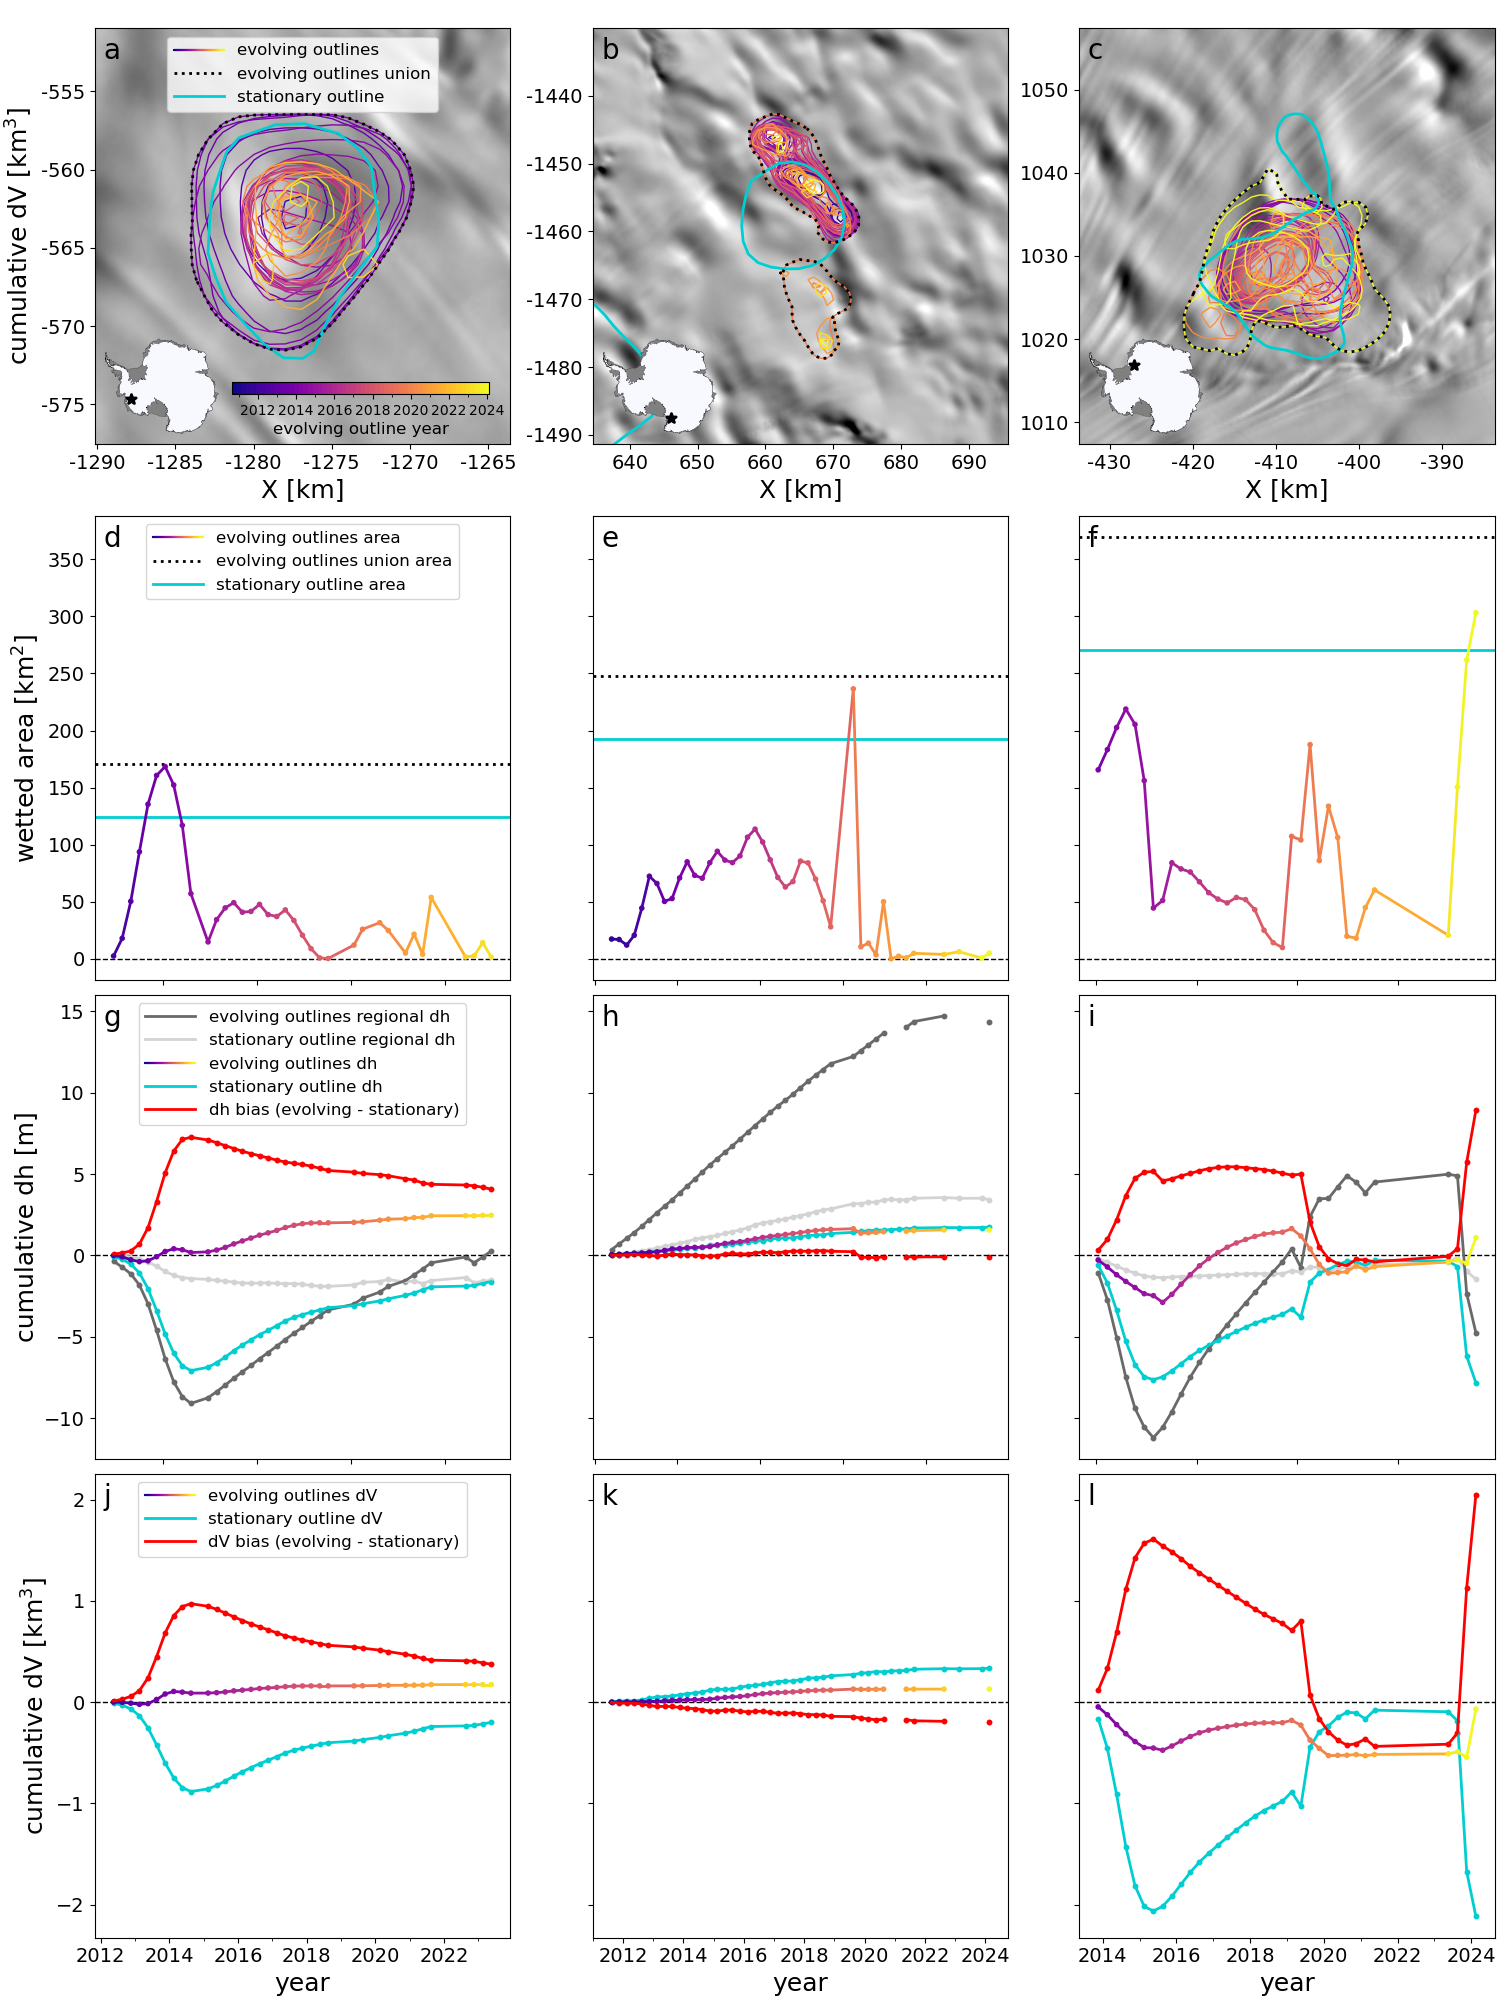

In [109]:
# Select lakes to be included in plot
selected_lakes = stationary_lakes_gdf[stationary_lakes_gdf['name'].isin(['WT', 'David_s1', 'Slessor_23'])]
desired_order = ['WT', 'David_s1', 'Slessor_23']
stationary_lakes_gdf_filtered = gpd.GeoDataFrame(pd.concat([selected_lakes[selected_lakes['name'] == name] for name in desired_order]))

# #TEMP
# stationary_lakes_gdf_filtered = stationary_lakes_gdf[stationary_lakes_gdf['name'].isin(['ConwaySubglacialLake', 'David_s1', 'Slessor_23'])]

# Number of rows and columns
nrows, ncols = 4, 3

# Create a 4x3 grid of plots (4 metrics, 3 lakes per metric)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20), constrained_layout=True)

# Define colors and linestyles that will be reused and create lines for legend
stationary_outline_color  = 'darkturquoise'
stationary_line = plt.Line2D((0, 1), (0, 0), color=stationary_outline_color, linestyle='solid', linewidth=2)
unary_union_line = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dotted', linewidth=2)

for row in range(1, nrows):
    # Share y-axis within each row but not between rows
    for col in range(ncols):
        ax[row, col].sharey(ax[row, 0])

# Pick colormap and make continuous cmap discrete for evolving outlines
colormap = 'plasma'
continuous_cmap = matplotlib.colormaps[colormap]
discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(cyc_dates['mid_cyc_dates'])-1)))

# Norm to time variable
norm = plt.Normalize(mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[0]), 
                     mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[-1]))

for idx, (lake_idx, lake) in enumerate(stationary_lakes_gdf_filtered.iterrows()):
    # Select the row by index and convert it to a GeoDataFrame
    lake_gdf = stationary_lakes_gdf_filtered.loc[[lake_idx]]
    lake_name = lake_gdf['name'].iloc[0]
    stationary_outline = lake_gdf['geometry']
    print('working on {}'.format(lake_name))
    
    # Attempt to open the evolving outlines GeoJSON file
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except fiona.errors.DriverError:
        print(f"File for {lake_name} not found. Skipping...")
        continue  # Skip the rest of the function if the file doesn't exist
    
    # Attempt to open the geometric calculations CSV file
    try:
        geom_calcs_df = pd.read_csv(os.path.join(
            os.getcwd(), 'output/geometric_calcs/compare_evolving_and_stationary_outlines/{}.csv'.format(lake_name)))
    except FileNotFoundError:
        print(f"CSV file for {lake_name} not found. Skipping...")
        continue  # Skip the rest of the function if the file doesn't exist
    
    # Convert of strings to datetime
    geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])

    
    # Panel - evolving outlines ------------------------------------------------------
    
    # Combine stationary outline with evolving outlines in unary union to plot all within bounds of plot
    # Use .buffer(0) to fix any invalid geometries
    all_outlines_unary_union = unary_union([lake_gdf['geometry'].iloc[0].buffer(0)] + list(evolving_outlines_gdf.geometry.buffer(0)))
    x_min, y_min, x_max, y_max = all_outlines_unary_union.bounds

    # Make x_min, y_min, x_max, and y_max define a square area centered at the original midpoints
    # Calculate the midpoints of the current bounds
    x_mid = (x_min + x_max) / 2
    y_mid = (y_min + y_max) / 2
    
    # Calculate the current spans of the x and y dimensions
    x_span = x_max - x_min
    y_span = y_max - y_min
    
    # Determine the maximum span to ensure square dimensions
    max_span = max(x_span, y_span)
    
    # Update the min and max values to match the new span, keeping the midpoint the same
    x_min = x_mid - max_span / 2
    x_max = x_mid + max_span / 2
    y_min = y_mid - max_span / 2
    y_max = y_mid + max_span / 2
    
    buffer_frac = 0.35
    x_buffer = abs(x_max-x_min)*buffer_frac
    y_buffer = abs(y_max-y_min)*buffer_frac

    # Plot MOA surface imagery
    mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
    mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
    moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
    ax[0,idx].imshow(moa_highres_da_subset[0,:,:], cmap='gray', clim=[14000, 17000], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])

    # Pick colormap and make continuous cmap discrete for evolving outlines
    colormap = 'plasma'
    continuous_cmap = matplotlib.colormaps[colormap]
    discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(cyc_dates['mid_cyc_dates'])-1)))
    
    # Norm to time variable
    norm = plt.Normalize(mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[0]), 
                         mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[-1]))
    
    # Use for loop to store each time slice as line segment to use in legend
    # And plot each evolving outline in the geodataframe color by date
    lines = []  # list of lines to be used for the legend
    for dt_idx, dt in enumerate(cyc_dates['mid_cyc_dates']):
        x = 1; y = 1
        line, = ax[0,idx].plot(x, y, color=discrete_cmap(norm(mdates.date2num(cyc_dates['mid_cyc_dates'][dt_idx]))))
        lines.append(line)
        
        # Filter rows that match the current time slice
        evolving_outlines_gdf_dt_sub = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
    
        # Plotting the subset if not empty
        if not evolving_outlines_gdf_dt_sub.empty:
            evolving_outlines_gdf_dt_sub.boundary.plot(ax=ax[0,idx], 
                color=discrete_cmap(norm(mdates.date2num(cyc_dates['mid_cyc_dates'][dt_idx]))), linewidth=1)
    
    # Plot stationary outline
    stationary_lakes_gdf['geometry'].boundary.plot(ax=ax[0,idx], color=stationary_outline_color, linewidth=2)

    # Create evolving outlines unary union and plot
    evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))
    evolving_outlines_union_gdf = gpd.GeoDataFrame(geometry=[evolving_outlines_unary_union], crs='3031')
    evolving_outlines_union_gdf.boundary.plot(ax=ax[0,idx], color='k', linestyle='dotted', linewidth=2)

    # Convert GeoDataFrame to EPSG:4326 for geodesic area calculation
    evolving_outlines_union_gdf = evolving_outlines_union_gdf.to_crs('4326')
    
    # Calculate the geodesic area for each polygon
    evolving_outlines_union_gdf['area (m^2)'] = evolving_outlines_union_gdf['geometry'].apply(calculate_area)

    # Plot inset map
    axIns = ax[0,idx].inset_axes([0.01, -0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    axIns.axis('off')
    # Plot star to indicate location
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=2, color='k', s=50, zorder=3)

    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax[0,idx].xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax[0,idx].yaxis.set_major_formatter(ticks_y)
    
    # Set axes limits
    ax[0,idx].set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))


    # Panel - da/dt ---------------------------------------------
    
    # Plot horizontal zero line for reference
    ax[1,idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
    # Plot stationary outline and evolving outlines unary union areas
    ax[1,idx].axhline(np.divide(lake_gdf['area (m^2)'], 1e6).values, 
        color=stationary_outline_color, linestyle='solid', linewidth=2)
    ax[1,idx].axhline(np.divide(evolving_outlines_union_gdf['area (m^2)'], 1e6).values, 
        color='k', linestyle='dotted', linewidth=2)

    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
    y=np.divide(geom_calcs_df['evolving_outlines_area (m^2)'], 1e6)
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)  # Set the values used for colormapping, using matplotlib dates for colors
    lc.set_linewidth(2)
    line = ax[1,idx].add_collection(lc)
    scatter = ax[1,idx].scatter(x, y, c=x, cmap=discrete_cmap, s=9, norm=norm, zorder=2)
    
    # # Get the maximum y value across all data for this lake
    # if idx == 0:
    #     max_y = max(
    #         np.divide(lake_gdf['area (m^2)'], 1e6).values[0],
    #         np.divide(evolving_outlines_union_gdf['area (m^2)'], 1e6).values[0],
    #         np.divide(geom_calcs_df['evolving_outlines_area (m^2)'], 1e6).max()
    #     )
    
    # # Set y limit with padding above the maximum value to avoid data plotting behind legend
    # ax[1,idx].set_ylim(bottom=None, top=max_y * 1.3)
    
    # Panel - dh/dt -------------------------------------------------------
    
    # Plot horizontal zero line for reference
    ax[2,idx].axhline(0, color='k', linestyle='dashed', linewidth=1)

    # Plot stationary outlines off-lake region dh
    ax[2,idx].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['stationary_outline_region_dh (m)']), color='lightgray', 
            linestyle='solid', linewidth=2)
    ax[2,idx].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['stationary_outline_region_dh (m)']), color='lightgray', 
            linestyle='solid', linewidth=2, s=5)

    # Plot evolving outlines off-lake region dh
    ax[2,idx].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['evolving_outlines_region_dh (m)']), color='dimgray', 
            linestyle='solid', linewidth=2)
    ax[2,idx].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['evolving_outlines_region_dh (m)']), color='dimgray', 
            linestyle='solid', linewidth=2, s=5)
    
    # Plot stationary outline time series
    ax[2,idx].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['stationary_outline_dh_corr (m)']), 
            color=stationary_outline_color, linestyle='solid', linewidth=2)
    ax[2,idx].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['stationary_outline_dh_corr (m)']), 
            color=stationary_outline_color, linestyle='solid', linewidth=2, s=5)

    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
    y=np.cumsum(geom_calcs_df['evolving_outlines_dh_corr (m)'])
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[2,idx].add_collection(lc)
    scatter = ax[2,idx].scatter(x, y, c=x, cmap=discrete_cmap, s=9, norm=norm, zorder=2)
    
    # Plot bias
    ax[2,idx].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
        np.cumsum(geom_calcs_df['bias_outlines_dh_corr (m)']), color='red', linestyle='solid', linewidth=2)
    ax[2,idx].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']),
        np.cumsum(geom_calcs_df['bias_outlines_dh_corr (m)']), color='red', linestyle='solid', linewidth=2, s=5)
    
    # Panel - dvol/dt --------------------------------------------------
    
    # Plot horizontal line at zero for reference
    ax[3,idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
    # Plot stationary outline time series
    ax[3,idx].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.divide(np.cumsum(geom_calcs_df['stationary_outline_dvol_corr (m^3)']), 1e9), 
        color=stationary_outline_color, linestyle='solid', linewidth=2)
    ax[3,idx].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.divide(np.cumsum(geom_calcs_df['stationary_outline_dvol_corr (m^3)']), 1e9), 
        color=stationary_outline_color, linestyle='solid', linewidth=2, s=5)

    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
    y=np.cumsum(np.divide(geom_calcs_df['evolving_outlines_dvol_corr (m^3)'], 1e9))
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[3,idx].add_collection(lc)
    scatter = ax[3,idx].scatter(x, y, c=x, cmap=discrete_cmap, s=9, norm=norm, zorder=2)
    
    # Plot bias
    ax[3,idx].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
        np.cumsum(np.divide(geom_calcs_df['bias_dvol_corr (m^3)'], 1e9)), 
            color='red', linestyle='solid', linewidth=2)
    ax[3,idx].scatter(mdates.date2num(geom_calcs_df['midcyc_datetime']),
        np.cumsum(np.divide(geom_calcs_df['bias_dvol_corr (m^3)'], 1e9)), 
            color='red', linestyle='solid', linewidth=2, s=5)

# Add colorbar, legends, and titles
idx=0  # Add colorbar and legends only to first row of plots

# Create colorbar
m = plt.cm.ScalarMappable(cmap=discrete_cmap)
m.set_array(np.array([mdates.date2num(date) for date in cyc_dates['mid_cyc_dates']]))
cax = inset_axes(ax[0,idx],
                 width='62%',
                 height='3%',
                 loc='lower left',
                 bbox_to_anchor=[0.33,0.12,1,1],  # [left, bottom, width, height]
                 bbox_transform=ax[0,idx].transAxes,
                 borderpad=0,
                 )

# Define major and minor years
major_years = [2012, 2014, 2016, 2018, 2020, 2022, 2024]
minor_years = list(range(2011, 2025))
major_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in major_years]
minor_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in minor_years]

cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_ticks(major_dates)
cbar.set_ticklabels(major_years)
cbar.ax.xaxis.set_minor_locator(ticker.FixedLocator(minor_dates))
cbar.set_label('evolving outline year', size=12, labelpad=3)

# Add legend
legend = ax[0,idx].legend([tuple(lines), unary_union_line, stationary_line], 
    ['evolving outlines',
     'evolving outlines union',
     'stationary outline'],
     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=12, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

# Add legend
legend = ax[1,idx].legend([tuple(lines), unary_union_line, stationary_line],
    ['evolving outlines area', 
     'evolving outlines union area', 
     'stationary outline area'], 
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=12, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

# Add legend
evolving_region = plt.Line2D((0, 1), (0, 0), color='dimgray', linestyle='solid', linewidth=2)
stationary_region = plt.Line2D((0, 1), (0, 0), color='lightgray', linestyle='solid', linewidth=2)
bias = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)
legend = ax[2,idx].legend(
    [evolving_region,
     stationary_region,
     tuple(lines),
     stationary_line,  
     bias],
    ['evolving outlines regional dh',
     'stationary outline regional dh',
     'evolving outlines dh',
     'stationary outline dh', 
     'dh bias (evolving - stationary)'],
     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=12, loc='upper center')

# Add legend
legend = ax[3,idx].legend([tuple(lines), stationary_line, bias],
    ['evolving outlines dV', 
     'stationary outline dV',
     'dV bias (evolving - stationary)'], 
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=12, loc='upper center')

# Set font sizes for all plots
TICK_SIZE = 14
LABEL_SIZE = 18

# Set common font sizes and axis labels
for i in range(nrows):
    for j in range(ncols):
        # Set tick sizes for all plots
        ax[i,j].tick_params(axis='both', labelsize=TICK_SIZE)
        
        # Configure row-specific settings
        if i == 0:
            ax[i,j].set_xlabel('X [km]', size=LABEL_SIZE)
            if j == 0:
                ax[i,j].set_ylabel('Y [km]', size=LABEL_SIZE)
        if i == 3:
            ax[i,j].set_xlabel('year', size=LABEL_SIZE)
            ax[i,j].xaxis.set_major_locator(mdates.YearLocator(base=2))
            ax[i,j].xaxis.set_minor_locator(mdates.YearLocator(base=1))
            ax[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        if j == 0:  # Leftmost column labels
            y_labels = ['wetted area [km$^2$]', 'cumulative dh [m]', 'cumulative dV [km$^3$]']
            ax[i,j].set_ylabel(y_labels[i-1], size=LABEL_SIZE)
        # Do not display redundant tick labels
        if 0 < i < 3:
            ax[i,j].set_xticklabels([])
        if i > 0:
            if j > 0:
                ax[i,j].tick_params(axis='y', which='both', labelleft=False)
            else:
                ax[i,j].tick_params(axis='y', which='both', labelleft=True)

# Adding annotations 'a', 'b', 'c', etc. at the top left of the subplot
for i, ax_i in enumerate(ax.flatten()):
    # `transform=ax.transAxes` makes coordinates relative to the axes (0,0 is bottom left and 1,1 is top right)
    ax_i.text(0.02, 0.98, chr(97 + i), transform=ax_i.transAxes, fontsize=20, va='top', ha='left')

# Cleanup
clear_output(wait=True)

# Save and close plot
# plt.savefig(OUTPUT_DIR + 'Fig2_lake_reexamination_results.png', dpi=300, bbox_inches='tight')
# plt.close()

In [71]:
plt.close('all')

# Fig. 3

In [ ]:
# Changes to make
# Make lakes w CS2/IS2 coverage time series terminate at end of CS2 era; relabel to CryoSat-2 era
# Make IS2 coverage panel include all lakes, CS2/IS2 coverage lakes and IS2 coverage lakes; relabel to ICESat-2 era
# Change color of evolving outlines curves to match color selected for CS2/IS2 coverage lakes and IS2 coverage lakes
# and a new color for the all lakes in the IS2 era panel or maybe keep multi-color line for CS2 era and all lakes in IS2 era?
# Or that may be too busy with all the ancillary lines, so perhaps just another column for all lakes during IS2 era
# Share x- and y-axes

In [87]:
# # Create a 3x2 grid of plots (three metrics, two time periods) plus extra row for location plot
# # Number of rows and columns
# nrows, ncols = 4, 2

# # fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 15))
# fig = plt.figure(figsize=(10, 15), constrained_layout=True)

# # Create GridSpec with different widths for each column
# CS2_IS2_time = len(subset_CS2_IS2_lakes_sum['midcyc_datetime'])
# IS2_time = len(superset_IS2_lakes_sum['midcyc_datetime'])
# width_ratios = [CS2_IS2_time, IS2_time]
# gs = GridSpec(nrows, ncols, figure=fig, width_ratios=width_ratios)

# # Creating subplots according to the GridSpec
# ax = [[fig.add_subplot(gs[row, col]) for col in range(ncols)] for row in range(nrows)]

# # For code compactness and readability
# dfs = [subset_CS2_IS2_lakes_sum, superset_IS2_lakes_sum]

# # Define colors and linestyles that will be reused and create lines for legend
# stationary_outline_color  = 'darkturquoise'
# stationary_line = plt.Line2D((0, 1), (0, 0), color=stationary_outline_color, linestyle='solid', linewidth=2)
# unary_union_line = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dotted', linewidth=2)

# for row in range(nrows):
#     # Share y-axis within each row but not between rows
#     for col in range(1, ncols):
#         ax[row][col].sharey(ax[row][0])

# # Pick colormap and make continuous cmap discrete for evolving outlines
# colormap = 'plasma'
# continuous_cmap = matplotlib.colormaps[colormap]
# discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(cyc_dates['mid_cyc_dates'])-1)))

# # Norm to time variable
# norm = plt.Normalize(mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[0]), 
#                      mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[-1]))

# # Use for loop to store each time slice as line segment to use in legend
# lines = []  # list of lines to be used for the legend
# for dt_idx, dt in enumerate(cyc_dates['mid_cyc_dates']):
#     x = 1; y = 1
#     line, = ax[0][0].plot(x, y, color=discrete_cmap(norm(mdates.date2num(cyc_dates['mid_cyc_dates'][dt_idx]))))
#     lines.append(line)

# # Panel - continental plots ---------------------------------------------
# ax0 = fig.add_subplot(gs[0, :])  # First row, span all columns
# map_width, map_height = 4.4,4.4
# inset_ax = inset_axes(ax0, width=map_width, height=map_height, loc='center')
# moa_2014_coastline.plot(ax=inset_ax, color='gray', edgecolor='k', linewidth=0.1, zorder=1)
# moa_2014_groundingline.plot(ax=inset_ax, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=1)
# stationary_lakes_gdf[stationary_lakes_gdf['CS2_SARIn_time_period'].isin(['2010.5-2018.75', '2013.75-2018.75'])].boundary.plot(ax=inset_ax, edgecolor='red', linestyle='solid', linewidth=0.75, zorder=2)
# stationary_lakes_gdf[stationary_lakes_gdf['CS2_SARIn_time_period'].isna()].boundary.plot(ax=inset_ax, edgecolor='blue', linestyle='solid', linewidth=0.75, zorder=2)

# # Plot CryoSat-2 SARIn mode masks
# gdf_SARIn_3_1.plot(ax=inset_ax, edgecolor='red', facecolor='red', alpha=0.25, zorder=3)
# gdf_SARIn_3_1_3_6_diff.plot(ax=inset_ax, edgecolor='red', facecolor='purple', alpha=0.25, zorder=3)
# CS2_SARIn_union_polygon = unary_union([gdf_SARIn_3_1.geometry[0], gdf_SARIn_3_1_3_6_diff.geometry[0]])
# CS2_SARIn_union_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [CS2_SARIn_union_polygon]}, crs='EPSG:3031')
# CS2_SARIn_union_gdf = CS2_SARIn_union_gdf.to_crs(epsg=4326)

# # Create ICESat-2 pole hole geodataframe
# center_x, center_y = 0, 0  # Geographic South Pole
# x, y = ll2ps(0, -88)
# radius = y  # Radius from Geographic South Pole to -88 S latitude (ICESat-2's southernmost coverage)
# IS2_pole_hole_poly = Point(center_x, center_y).buffer(radius)
# IS2_pole_hole_gdf = gpd.GeoDataFrame(index=[0], geometry=[IS2_pole_hole_poly], crs="EPSG:3031")
# IS2_pole_hole_gdf = IS2_pole_hole_gdf.to_crs(epsg=4326)

# # IS2 interior to CS2 SARIn mode coverage
# IS2_interior_poly = Polygon(shell=CS2_SARIn_union_gdf.geometry[0].interiors[0].coords, 
#                             holes=[IS2_pole_hole_gdf.geometry[0].exterior.coords])
# IS2_interior_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [IS2_interior_poly]}, crs='EPSG:4326')
# IS2_interior_gdf = IS2_interior_gdf.to_crs(epsg=3031)
# IS2_interior_gdf.plot(ax=inset_ax, edgecolor='blue', facecolor='green', alpha=0.25, zorder=3)

# inset_ax.set_aspect('equal')
# inset_ax.axis('off')
# ax0.axis('off')

# for idx in [0,1]:  # For loop through two columns
#     ax[0][idx].axis('off')
  
#     # Panel - da/dt ---------------------------------------------
#     # Filter union_evolving_lakes_gdf based on idx
#     if idx == 0:
#         filtered_union_evolving_lakes_gdf = union_evolving_lakes_gdf[union_evolving_lakes_gdf['CS2_SARIn_time_period'].notnull()]
#     else:
#         filtered_union_evolving_lakes_gdf = union_evolving_lakes_gdf[union_evolving_lakes_gdf['CS2_SARIn_time_period'].isnull()]
  
#     # Plot horizontal line at zero for reference
#     ax[1][idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
#     # Plot stationary outline and evolving outlines unary union areas
#     ax[1][idx].axhline(np.divide(dfs[idx]['stationary_outline_area (m^2)'][0], 1e6), color=stationary_outline_color, linestyle='solid', linewidth=2)
#     # ax[1][idx].axhline(np.divide(dfs[idx]['stationary_outline_area (m^2)'][0], 1e6), color=stationary_outline_color, linestyle='solid', linewidth=2)
#     ax[1][idx].axhline(np.divide(filtered_union_evolving_lakes_gdf['area (m^2)'].sum(), 1e6), color='k', linestyle='dotted', linewidth=2)
    
#     # Plot multi-colored line and scatter for data points
#     x=mdates.date2num(dfs[idx]['midcyc_datetime'])
#     y=np.divide(dfs[idx]['evolving_outlines_area (m^2)'], 1e6)
    
#     # Create points and segments for LineCollection
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
#     # Create a LineCollection, using the discrete colormap and norm
#     lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
#     lc.set_array(x)  # Set the values used for colormapping, using matplotlib dates for colors
#     lc.set_linewidth(2)
#     line = ax[1][idx].add_collection(lc)
#     scatter = ax[1][idx].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)  # Scatter if I get legend line to work
    
#     # # Format the x-axis to display years only
#     # ax[1][idx].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
#     # ax[1][idx].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
#     # ax[1][idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
#     # Panel - dh/dt -------------------------------------------------------
    
#     # Plot horizontal zero line for reference
#     ax[2][idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
#     # Plot stationary outlines off-lake region dh
#     ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
#         np.cumsum(dfs[idx]['stationary_outline_region_dh (m)']), color='lightgray', linestyle='solid', linewidth=2)
#         # np.cumsum(dfs[idx]['stationary_outline_region_dh (m)']), color='lightgray', linestyle='solid', linewidth=2)

#     # Plot evolving outlines off-lake region dh
#     ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
#         np.cumsum(dfs[idx]['evolving_outlines_region_dh (m)']), color='dimgray', linestyle='solid', linewidth=2)
    
#     # Plot stationary outline time series
#     ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
#         np.cumsum(dfs[idx]['stationary_outline_dh_corr (m)']), color=stationary_outline_color, linestyle='solid', linewidth=2)
#         # np.cumsum(dfs[idx]['stationary_outline_dh_corr (m)']), color=stationary_outline_color, linestyle='solid', linewidth=2)

#     # Plot multi-colored line and scatter for data points
#     x=mdates.date2num(dfs[idx]['midcyc_datetime'])
#     y=np.cumsum(dfs[idx]['evolving_outlines_dh_corr (m)'])
    
#     # Create points and segments for LineCollection
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
#     # Create a LineCollection, using the discrete colormap and norm
#     lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
#     lc.set_array(x)
#     lc.set_linewidth(2)
#     line = ax[2][idx].add_collection(lc)
#     scatter = ax[2][idx].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)  # Scatter if I can figure out how to put in legend
    
#     # Plot bias
#     ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']),
#         np.cumsum(dfs[idx]['bias_outlines_dh_corr (m)']), color='red', linestyle='solid', linewidth=2)
    
#     # # Format the x-axis to display years only
#     # ax[2][idx].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
#     # ax[2][idx].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
#     # ax[2][idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
#     # Panel D - dvol/dt --------------------------------------------------
    
#     # Plot horizontal line at zero for reference
#     ax[3][idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
#     # Plot stationary outline time series
#     ax[3][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
#         np.divide(np.cumsum(dfs[idx]['stationary_outline_dvol_corr (m^3)']), 1e9), 
#         # np.divide(np.cumsum(dfs[idx]['stationary_outline_dvol_corr (m^3)']), 1e9), 
#         color=stationary_outline_color, linestyle='solid', linewidth=2)
    
#     # Plot multi-colored line and scatter for data points
#     x=mdates.date2num(dfs[idx]['midcyc_datetime'])
#     y=np.cumsum(np.divide(dfs[idx]['evolving_outlines_dvol_corr (m^3)'], 1e9))
    
#     # Create points and segments for LineCollection
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
#     # Create a LineCollection, using the discrete colormap and norm
#     lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
#     lc.set_array(x)
#     lc.set_linewidth(2)
#     line = ax[3][idx].add_collection(lc)
#     scatter = ax[3][idx].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)
    
#     # Plot bias
#     ax[3][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']),
#         np.cumsum(np.divide(dfs[idx]['bias_dvol_corr (m^3)'], 1e9)), color='red', linestyle='solid', linewidth=2)
    
#     # # Format the x-axis to display years only
#     # ax[3][idx].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
#     # ax[3][idx].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
#     # ax[3][idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
#     # # Add colorbar, legends, and titles
#     # ax[3][idx].set_xlabel('year', size=14)

# # for idx in [1,2,3]:
#     # # Plot vertical lines to indicate CS2 SARIn mode mask moving inland and ICESat-2 era start
#     # ax[idx][0].axvline(cyc_dates[cyc_dates['cyc_start_dates'] == '2013-10-01 22:30:00']['cyc_start_dates'], 
#     #                    color='k', linestyle='solid', linewidth=1, ymin=-50, ymax=1)
#     # ax[idx][0].axvline(cyc_dates[cyc_dates['dataset'] == 'IS2_ATL15'].iloc[0]['cyc_start_dates'], 
#     #                    color='k', linestyle='solid', linewidth=1, ymin=-50, ymax=1)
#     # Add a triangle to indicate an event on the x-axis
#     # event_x = cyc_dates[cyc_dates['cyc_start_dates'] == '2013-10-01 22:30:00']['cyc_start_dates']
#     # ax[0][0].annotate('SARIn mode expands', xy=(event_x, -1), xytext=(event_x, -0.1),
#     #         textcoords='data', arrowprops=dict(arrowstyle='<|-|>', color='red', mutation_scale=15))


# # # Add text label near the vertical line
# # ax[1][0].text(cyc_dates[cyc_dates['cyc_start_dates'] == '2013-10-01 22:30:00']['cyc_start_dates'], 
# #         -15, 
# #         'SARIn mode expands',
# #         horizontalalignment='left', verticalalignment='center', color='k', fontsize=10)
# # ax[1][0].text(cyc_dates[cyc_dates['dataset'] == 'IS2_ATL15'].iloc[0]['cyc_start_dates'], 
# #         -15, 
# #         'ICESat-2 era begins',
# #         horizontalalignment='left', verticalalignment='center', color='k', fontsize=10)

# # Add legends
# # Creating custom legend entries
# CS2_IS2_active_lakes_patch = mpatches.Circle((0.5, 0.5), 100, edgecolor='red', facecolor='red', alpha=1, transform=ax[0][0].transAxes)
# # IS2_active_lakes_patch = mpatches.Circle((0.5, 0.5), 100, edgecolor='green', facecolor='green', alpha=1, transform=ax[0][0].transAxes)
# CS2_SARIn_patch = mpatches.Patch(edgecolor='red', facecolor='red', alpha=0.1)
# IS2_patch = mpatches.Patch(edgecolor='blue', facecolor='blue', alpha=0.1)
# class HandlerCircle(HandlerPatch):
#     def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
#         # This function will create a circle at the appropriate location and size
#         radius = 0.1 * min(width, height)
#         circle = mpatches.Circle(xy=(0.5*width - xdescent, 0.5*height - ydescent), radius=radius)
#         # Update with original handle properties
#         self.update_prop(circle, orig_handle, legend)
#         circle.set_transform(trans)
#         return [circle]
        
# ax[0][0].legend([CS2_SARIn_patch, IS2_patch, CS2_IS2_active_lakes_patch, 
#                  # IS2_active_lakes_patch
#                 ],
#     ['CryoSat-2 SARIn and ICESat-2 coverage', 'only ICESat-2 coverage',
#     'active subglacial lakes (colored by coverage)'],
#     handler_map={mpatches.Circle: HandlerCircle()},
#     loc='lower left')

# legend = ax[1][0].legend([tuple(lines), unary_union_line, stationary_line],
#     ['evolving outlines area', 
#      'evolving outlines union area', 
#      'stationary outline area'],
#     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
#     fontsize=10, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

# evolving_region = plt.Line2D((0, 1), (0, 0), color='dimgray', linestyle='solid', linewidth=2)
# stationary_region = plt.Line2D((0, 1), (0, 0), color='lightgray', linestyle='solid', linewidth=2)
# bias = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)
# legend = ax[2][0].legend(
#     [evolving_region,
#      stationary_region,
#      tuple(lines),
#      stationary_line,  
#      bias],
#     ['evolving outlines off-lake dh',
#      'stationary outline off-lake dh',
#      'evolving outlines dh$_{corr}$',
#      'stationary outline dh$_{corr}$', 
#      'dh$_{corr}$ bias (evolving - stationary)'],
#      handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
#     fontsize=10, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

# legend = ax[3][0].legend([tuple(lines), stationary_line, bias],
#     ['evolving outlines dvol$_{corr}$', 
#      'stationary outline  dvol$_{corr}$',
#      'dvol$_{corr}$ bias (evolving - stationary)'], 
#     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
#     fontsize=10, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

# for row in [1,2]:
#     for col in [0,1]:
#         # Remove x tick labels
#         ax[row][col].set_xticklabels([])

# for row in [1,2,3]:
#     for col in [1]:
#         # Remove y tick labels  
#         ax[row][col].yaxis.set_tick_params(labelleft=False)

# # Set axes titles
# ax[1][0].set_ylabel('wetted area [km$^2$]', size=12)
# ax[2][0].set_ylabel('cumulative dh [m]', size=12)
# ax[3][0].set_ylabel('cumulative dvol$_{corr}$ [km$^3$]', size=12)

# # Plot titles for the first two subplots
# ax[1][0].set_title('Lakes with CryoSat-2 SARIn and ICESat-2 coverage')
# ax[1][1].set_title('Lakes with only\nICESat-2 coverage')
    
# # Adding annotations 'a', 'b', 'c' at the top left of the subplot
# ax_array = np.array(ax)  # Convert gridspec list of lists into numpy array to use .flatten() method
# char_index = 97  # ASCII value for 'a'
# for i, ax_i in enumerate(ax_array.flatten()):
#     if i == 1:
#         continue  # Skip the second element (index 1)
#     # `transform=ax.transAxes` makes coordinates relative to the axes (0,0 is bottom left and 1,1 is top right)
#     ax_i.text(0.02, 0.98, chr(char_index), transform=ax_i.transAxes, fontsize=12, weight='bold', va='top', ha='left')
#     char_index += 1 # Increment the ASCII index to get the next character

# # Save and close plot
# plt.savefig(OUTPUT_DIR + 'Fig3_lake_reexamination_results_continentally_integrated.png',
#     dpi=300, bbox_inches='tight')

In [ ]:
# # Create a 3x1 grid of plots (three metrics, three different time series) plus extra row for location plot
# # Number of rows and columns
# nrows, ncols = 4, 3

# # fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 15))
# fig = plt.figure(figsize=(10, 15), constrained_layout=True)

# # Create GridSpec with different widths for each column
# CS2_IS2_time = len(subset_CS2_IS2_lakes_sum['midcyc_datetime'])
# width_ratios = [CS2_IS2_time, IS2_time, IS2_time]
# gs = GridSpec(nrows, ncols, figure=fig, width_ratios=width_ratios)

# # Creating subplots according to the GridSpec
# ax = [[fig.add_subplot(gs[row, col]) for col in range(ncols)] for row in range(nrows)]

# # For code compactness and readability
# dfs = [subset_CS2_IS2_lakes_sum, superset_IS2_lakes_sum, subset_noCS2_IS2_lakes_sum]

# # Define colors and linestyles that will be reused and create lines for legend
# stationary_outline_color  = 'darkturquoise'
# stationary_line = plt.Line2D((0, 1), (0, 0), color=stationary_outline_color, linestyle='solid', linewidth=2)
# unary_union_line = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dotted', linewidth=2)

# for row in range(nrows):
#     # Share y-axis within each row but not between rows
#     for col in range(1, ncols):
#         ax[row][col].sharey(ax[row][0])

# # Pick colormap and make continuous cmap discrete for evolving outlines
# colormap = 'plasma'
# continuous_cmap = matplotlib.colormaps[colormap]
# discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(cyc_dates['mid_cyc_dates'])-1)))

# # Norm to time variable
# norm = plt.Normalize(mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[0]), 
#                      mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[-1]))

# # Use for loop to store each time slice as line segment to use in legend
# lines = []  # list of lines to be used for the legend
# for dt_idx, dt in enumerate(cyc_dates['mid_cyc_dates']):
#     x = 1; y = 1
#     line, = ax[0][0].plot(x, y, color=discrete_cmap(norm(mdates.date2num(cyc_dates['mid_cyc_dates'][dt_idx]))))
#     lines.append(line)

# # Panel - continental plots ---------------------------------------------
# ax0 = fig.add_subplot(gs[0, :])  # first row, span all columns
# map_width, map_height = 4.4,4.4
# inset_ax = inset_axes(ax0, width=map_width, height=map_height, loc='center')
# moa_2014_coastline.plot(ax=inset_ax, color='gray', edgecolor='k', linewidth=0.1, zorder=1)
# moa_2014_groundingline.plot(ax=inset_ax, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=1)
# stationary_lakes_gdf[stationary_lakes_gdf['CS2_SARIn_time_period'].isin(['2010.5-2018.75', '2013.75-2018.75'])].boundary.plot(ax=inset_ax, edgecolor='red', linestyle='solid', linewidth=0.75, zorder=2)
# stationary_lakes_gdf[stationary_lakes_gdf['CS2_SARIn_time_period'].isna()].boundary.plot(ax=inset_ax, edgecolor='blue', linestyle='solid', linewidth=0.75, zorder=2)

# # Plot CryoSat-2 SARIn mode masks
# gdf_SARIn_3_1.plot(ax=inset_ax, edgecolor='red', facecolor='red', alpha=0.25, zorder=3)
# gdf_SARIn_3_1_3_6_diff.plot(ax=inset_ax, edgecolor='red', facecolor='red', alpha=0.25, zorder=3)
# CS2_SARIn_union_polygon = unary_union([gdf_SARIn_3_1.geometry[0], gdf_SARIn_3_1_3_6_diff.geometry[0]])
# CS2_SARIn_union_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [CS2_SARIn_union_polygon]}, crs='EPSG:3031')
# CS2_SARIn_union_gdf = CS2_SARIn_union_gdf.to_crs(epsg=4326)

# # New polygon from the hole's boundary
# pole_hole_center = Point(0, 0)  # Geographic South Pole
# pole_hole_poly = pole_hole_center.buffer(radius_from_88_to_pole*1e3)
# pole_hole_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [pole_hole_poly]}, crs='EPSG:3031')
# pole_hole_gdf = pole_hole_gdf.to_crs(epsg=4326)

# # IS2 interior to CS2 SARIn mode coverage
# IS2_interior_poly = Polygon(shell=CS2_SARIn_union_gdf.geometry[0].interiors[0].coords, holes=[pole_hole_gdf.geometry[0].exterior.coords])
# IS2_interior_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [IS2_interior_poly]}, crs='EPSG:4326')
# IS2_interior_gdf = IS2_interior_gdf.to_crs(epsg=3031)
# IS2_interior_gdf.plot(ax=inset_ax, edgecolor='blue', facecolor='blue', alpha=0.25, zorder=3)

# inset_ax.set_aspect('equal')
# inset_ax.axis('off')
# ax0.axis('off')

# for idx in [0,1,2]:  # For loop through three columns
#     ax[0][idx].axis('off')

#     # Panel - da/dt ---------------------------------------------
#     # Filter union_evolving_lakes_gdf based on idx
#     if idx == 0:
#         filtered_union_evolving_lakes_gdf = union_evolving_lakes_gdf[union_evolving_lakes_gdf['CS2_SARIn_time_period'].notnull()]
#     elif idx == 1:
#         filtered_union_evolving_lakes_gdf = union_evolving_lakes_gdf[union_evolving_lakes_gdf['CS2_SARIn_time_period'].isnull()]
#     else:
#         filtered_union_evolving_lakes_gdf = union_evolving_lakes_gdf

#     # Plot horizontal line at zero for reference
#     ax[1][idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
#     # Plot stationary outline and evolving outlines unary union areas
#     ax[1][idx].axhline(np.divide(dfs[idx]['stationary_outline_area (m^2)'][0], 1e6), color=stationary_outline_color, linestyle='solid', linewidth=2)
#     # ax[1][idx].axhline(np.divide(dfs[idx]['stationary_outline_area (m^2)'][0], 1e6), color=stationary_outline_color, linestyle='solid', linewidth=2)
#     ax[1][idx].axhline(np.divide(filtered_union_evolving_lakes_gdf['area (m^2)'].sum(), 1e6), color='k', linestyle='dotted', linewidth=2)
    
#     # Plot multi-colored line and scatter for data points
#     x=mdates.date2num(dfs[idx]['midcyc_datetime'])
#     y=np.divide(dfs[idx]['evolving_outlines_area (m^2)'], 1e6)
    
#     # Create points and segments for LineCollection
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
#     # Create a LineCollection, using the discrete colormap and norm
#     lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
#     lc.set_array(x)  # Set the values used for colormapping, using matplotlib dates for colors
#     lc.set_linewidth(2)
#     line = ax[1][idx].add_collection(lc)
#     scatter = ax[1][idx].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)  # Scatter if I get legend line to work
    
#     # Format the x-axis to display years only
#     ax[1][idx].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
#     ax[1][idx].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
#     ax[1][idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
#     # Panel - dh/dt -------------------------------------------------------
    
#     # Plot horizontal zero line for reference
#     ax[2][idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
#     # Plot stationary outlines off-lake region dh
#     ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
#         np.cumsum(dfs[idx]['stationary_outline_region_dh (m)']), color='lightgray', linestyle='solid', linewidth=2)
#         # np.cumsum(dfs[idx]['stationary_outline_region_dh (m)']), color='lightgray', linestyle='solid', linewidth=2)

#     # Plot evolving outlines off-lake region dh
#     ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
#         np.cumsum(dfs[idx]['evolving_outlines_region_dh (m)']), color='dimgray', linestyle='solid', linewidth=2)
    
#     # Plot stationary outline time series
#     ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
#         np.cumsum(dfs[idx]['stationary_outline_dh_corr (m)']), color=stationary_outline_color, linestyle='solid', linewidth=2)
#         # np.cumsum(dfs[idx]['stationary_outline_dh_corr (m)']), color=stationary_outline_color, linestyle='solid', linewidth=2)

#     # Plot multi-colored line and scatter for data points
#     x=mdates.date2num(dfs[idx]['midcyc_datetime'])
#     y=np.cumsum(dfs[idx]['evolving_outlines_dh_corr (m)'])
    
#     # Create points and segments for LineCollection
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
#     # Create a LineCollection, using the discrete colormap and norm
#     lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
#     lc.set_array(x)
#     lc.set_linewidth(2)
#     line = ax[2][idx].add_collection(lc)
#     scatter = ax[2][idx].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)  # Scatter if I can figure out how to put in legend
    
#     # Plot bias
#     ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']),
#         np.cumsum(dfs[idx]['bias_outlines_dh_corr (m)']), color='red', linestyle='solid', linewidth=2)
    
#     # Format the x-axis to display years only
#     ax[2][idx].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
#     ax[2][idx].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
#     ax[2][idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
#     # Panel D - dvol/dt --------------------------------------------------
    
#     # Plot horizontal line at zero for reference
#     ax[3][idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
#     # Plot stationary outline time series
#     ax[3][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
#         np.divide(np.cumsum(dfs[idx]['stationary_outline_dvol_corr (m^3)']), 1e9), 
#         # np.divide(np.cumsum(dfs[idx]['stationary_outline_dvol_corr (m^3)']), 1e9), 
#         color=stationary_outline_color, linestyle='solid', linewidth=2)
    
#     # Plot multi-colored line and scatter for data points
#     x=mdates.date2num(dfs[idx]['midcyc_datetime'])
#     y=np.cumsum(np.divide(dfs[idx]['evolving_outlines_dvol_corr (m^3)'], 1e9))
    
#     # Create points and segments for LineCollection
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
#     # Create a LineCollection, using the discrete colormap and norm
#     lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
#     lc.set_array(x)
#     lc.set_linewidth(2)
#     line = ax[3][idx].add_collection(lc)
#     scatter = ax[3][idx].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)
    
#     # Plot bias
#     ax[3][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']),
#         np.cumsum(np.divide(dfs[idx]['bias_dvol_corr (m^3)'], 1e9)), color='red', linestyle='solid', linewidth=2)
    
#     # Format the x-axis to display years only
#     ax[3][idx].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
#     ax[3][idx].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
#     ax[3][idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
#     # Add colorbar, legends, and titles
#     ax[3][idx].set_xlabel('year', size=14)

# # for idx in [1,2,3]:
#     # # Plot vertical lines to indicate CS2 SARIn mode mask moving inland and ICESat-2 era start
#     # ax[idx][0].axvline(cyc_dates[cyc_dates['cyc_start_dates'] == '2013-10-01 22:30:00']['cyc_start_dates'], 
#     #                    color='k', linestyle='solid', linewidth=1, ymin=-50, ymax=1)
#     # ax[idx][0].axvline(cyc_dates[cyc_dates['dataset'] == 'IS2_ATL15'].iloc[0]['cyc_start_dates'], 
#     #                    color='k', linestyle='solid', linewidth=1, ymin=-50, ymax=1)
#     # Add a triangle to indicate an event on the x-axis
#     # event_x = cyc_dates[cyc_dates['cyc_start_dates'] == '2013-10-01 22:30:00']['cyc_start_dates']
#     # ax[0][0].annotate('SARIn mode expands', xy=(event_x, -1), xytext=(event_x, -0.1),
#     #         textcoords='data', arrowprops=dict(arrowstyle='<|-|>', color='red', mutation_scale=15))


# # # Add text label near the vertical line
# # ax[1][0].text(cyc_dates[cyc_dates['cyc_start_dates'] == '2013-10-01 22:30:00']['cyc_start_dates'], 
# #         -15, 
# #         'SARIn mode expands',
# #         horizontalalignment='left', verticalalignment='center', color='k', fontsize=10)
# # ax[1][0].text(cyc_dates[cyc_dates['dataset'] == 'IS2_ATL15'].iloc[0]['cyc_start_dates'], 
# #         -15, 
# #         'ICESat-2 era begins',
# #         horizontalalignment='left', verticalalignment='center', color='k', fontsize=10)

# # Add legends
# # Creating custom legend entries
# CS2_IS2_active_lakes_patch = mpatches.Circle((0.5, 0.5), 100, edgecolor='red', facecolor='red', alpha=1, transform=ax[0][0].transAxes)
# # IS2_active_lakes_patch = mpatches.Circle((0.5, 0.5), 100, edgecolor='green', facecolor='green', alpha=1, transform=ax[0][0].transAxes)
# CS2_SARIn_patch = mpatches.Patch(edgecolor='red', facecolor='red', alpha=0.1)
# IS2_patch = mpatches.Patch(edgecolor='blue', facecolor='blue', alpha=0.1)
# class HandlerCircle(HandlerPatch):
#     def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
#         # This function will create a circle at the appropriate location and size
#         radius = 0.1 * min(width, height)
#         circle = mpatches.Circle(xy=(0.5*width - xdescent, 0.5*height - ydescent), radius=radius)
#         # Update with original handle properties
#         self.update_prop(circle, orig_handle, legend)
#         circle.set_transform(trans)
#         return [circle]
        
# ax[0][0].legend([CS2_SARIn_patch, IS2_patch, CS2_IS2_active_lakes_patch, 
#                  # IS2_active_lakes_patch
#                 ],
#     ['CryoSat-2 SARIn and ICESat-2 coverage', 'only ICESat-2 coverage',
#     'active subglacial lakes (colored by coverage)'],
#     handler_map={mpatches.Circle: HandlerCircle()},
#     loc='lower left')

# legend = ax[1][0].legend([tuple(lines), unary_union_line, stationary_line],
#     ['evolving outlines area', 
#      'evolving outlines union area', 
#      'stationary outline area'],
#     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
#     fontsize=10, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

# evolving_region = plt.Line2D((0, 1), (0, 0), color='dimgray', linestyle='solid', linewidth=2)
# stationary_region = plt.Line2D((0, 1), (0, 0), color='lightgray', linestyle='solid', linewidth=2)
# bias = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)
# legend = ax[2][0].legend(
#     [evolving_region,
#      stationary_region,
#      tuple(lines),
#      stationary_line,  
#      bias],
#     ['evolving outlines off-lake dh',
#      'stationary outline off-lake dh',
#      'evolving outlines dh$_{corr}$',
#      'stationary outline dh$_{corr}$', 
#      'dh$_{corr}$ bias (evolving - stationary)'],
#      handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
#     fontsize=10, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

# legend = ax[3][0].legend([tuple(lines), stationary_line, bias],
#     ['evolving outlines dvol$_{corr}$', 
#      'stationary outline  dvol$_{corr}$',
#      'dvol$_{corr}$ bias (evolving - stationary)'], 
#     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
#     fontsize=10, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

# for row in [1,2]:
#     for col in [0,1,2]:
#         # Remove x tick labels
#         ax[row][col].set_xticklabels([])

# for row in [1,2,3]:
#     for col in [1,2]:
#         # Remove y tick labels  
#         ax[row][col].yaxis.set_tick_params(labelleft=False)

# # Set axes titles
# ax[1][0].set_ylabel('wetted area [km$^2$]', size=12)
# ax[2][0].set_ylabel('cumulative dh [m]', size=12)
# ax[3][0].set_ylabel('cumulative dvol$_{corr}$ [km$^3$]', size=12)

# # Plot titles for the first two subplots
# ax[1][0].set_title('Lakes with CryoSat-2 SARIn and ICESat-2 coverage')
# ax[1][1].set_title('Lakes with only\nICESat-2 coverage')
# ax[1][2].set_title('All lakes during\nICESat-2 era')

# # Adding annotations 'a', 'b', 'c' at the top left of the subplot
# ax_array = np.array(ax)  # Convert gridspec list of lists into numpy array to use .flatten() method
# char_index = 97  # ASCII value for 'a'
# for i, ax_i in enumerate(ax_array.flatten()):
#     if i == 1:
#         continue  # Skip the second element (index 1)
#     # `transform=ax.transAxes` makes coordinates relative to the axes (0,0 is bottom left and 1,1 is top right)
#     ax_i.text(0.02, 0.98, chr(char_index), transform=ax_i.transAxes, fontsize=12, weight='bold', va='top', ha='left')
#     char_index += 1 # Increment the ASCII index to get the next character

# # Save and close plot
# plt.savefig(OUTPUT_DIR + 'Fig3_lake_reexamination_results_continentally_integrated.png',
#     dpi=300, bbox_inches='tight')

TypeError: 'Axes' object is not subscriptable

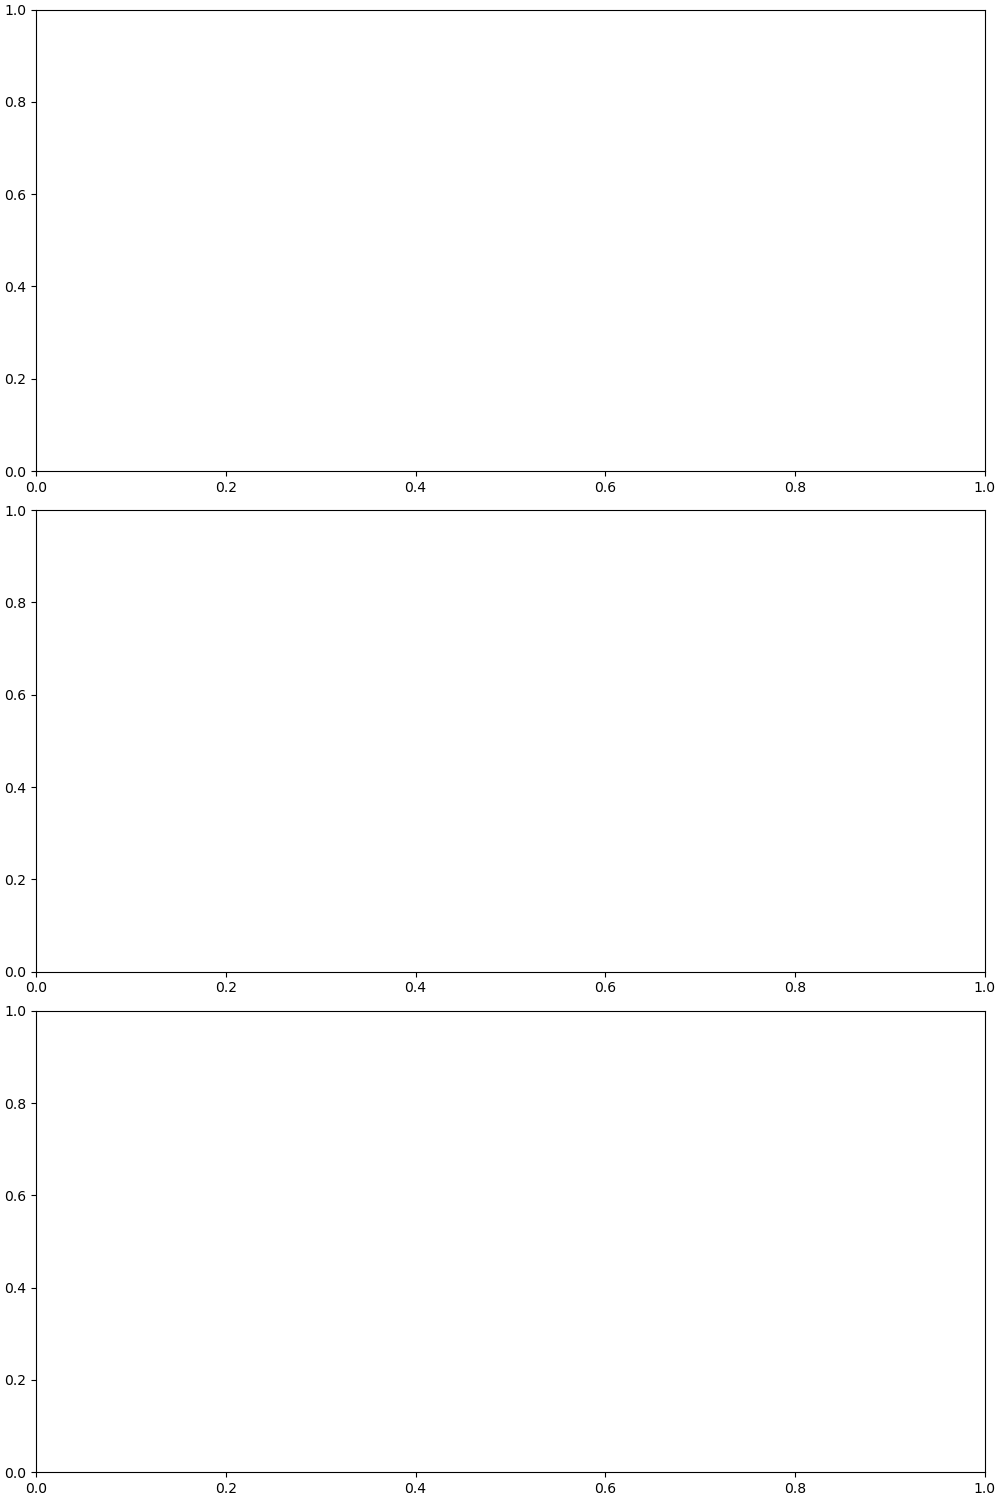

In [89]:
# Create a 3x1 grid of plots (three metrics, three different time series) plus extra row for location plot
# Number of rows and columns
nrows, ncols = 3, 1

fig, ax = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# Define colors and linestyles that will be reused and create lines for legend
stationary_outline_color  = 'darkturquoise'
stationary_line = plt.Line2D((0, 1), (0, 0), color=stationary_outline_color, linestyle='solid', linewidth=2)
unary_union_line = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dotted', linewidth=2)

# Pick colormap and make continuous cmap discrete for evolving outlines
colormap = 'plasma'
continuous_cmap = matplotlib.colormaps[colormap]
discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(cyc_dates['mid_cyc_dates'])-1)))

# Norm to time variable
norm = plt.Normalize(mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[0]), 
                     mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[-1]))

# Use for loop to store each time slice as line segment to use in legend
lines = []  # list of lines to be used for the legend
for dt_idx, dt in enumerate(cyc_dates['mid_cyc_dates']):
    x = 1; y = 1
    line, = ax[0][0].plot(x, y, color=discrete_cmap(norm(mdates.date2num(cyc_dates['mid_cyc_dates'][dt_idx]))))
    lines.append(line)

# Panel - continental plots ---------------------------------------------
ax0 = fig.add_subplot(gs[0, :])  # first row, span all columns
map_width, map_height = 4.4,4.4
inset_ax = inset_axes(ax0, width=map_width, height=map_height, loc='center')
moa_2014_coastline.plot(ax=inset_ax, color='gray', edgecolor='k', linewidth=0.1, zorder=1)
moa_2014_groundingline.plot(ax=inset_ax, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=1)
stationary_lakes_gdf[stationary_lakes_gdf['CS2_SARIn_time_period'].isin(['2010.5-2018.75', '2013.75-2018.75'])].boundary.plot(ax=inset_ax, edgecolor='red', linestyle='solid', linewidth=0.75, zorder=2)
stationary_lakes_gdf[stationary_lakes_gdf['CS2_SARIn_time_period'].isna()].boundary.plot(ax=inset_ax, edgecolor='blue', linestyle='solid', linewidth=0.75, zorder=2)

# Plot CryoSat-2 SARIn mode masks
gdf_SARIn_3_1.plot(ax=inset_ax, edgecolor='red', facecolor='red', alpha=0.25, zorder=3)
gdf_SARIn_3_1_3_6_diff.plot(ax=inset_ax, edgecolor='red', facecolor='red', alpha=0.25, zorder=3)
CS2_SARIn_union_polygon = unary_union([gdf_SARIn_3_1.geometry[0], gdf_SARIn_3_1_3_6_diff.geometry[0]])
CS2_SARIn_union_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [CS2_SARIn_union_polygon]}, crs='EPSG:3031')
CS2_SARIn_union_gdf = CS2_SARIn_union_gdf.to_crs(epsg=4326)

# New polygon from the hole's boundary
pole_hole_center = Point(0, 0)  # Geographic South Pole
pole_hole_poly = pole_hole_center.buffer(radius_from_88_to_pole*1e3)
pole_hole_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [pole_hole_poly]}, crs='EPSG:3031')
pole_hole_gdf = pole_hole_gdf.to_crs(epsg=4326)

# IS2 interior to CS2 SARIn mode coverage
IS2_interior_poly = Polygon(shell=CS2_SARIn_union_gdf.geometry[0].interiors[0].coords, holes=[pole_hole_gdf.geometry[0].exterior.coords])
IS2_interior_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [IS2_interior_poly]}, crs='EPSG:4326')
IS2_interior_gdf = IS2_interior_gdf.to_crs(epsg=3031)
IS2_interior_gdf.plot(ax=inset_ax, edgecolor='blue', facecolor='blue', alpha=0.25, zorder=3)

inset_ax.set_aspect('equal')
inset_ax.axis('off')
ax0.axis('off')

for idx in [0,1,2]:  # For loop through three columns
    ax[0][idx].axis('off')

    # Panel - da/dt ---------------------------------------------
    # Filter union_evolving_lakes_gdf based on idx
    if idx == 0:
        filtered_union_evolving_lakes_gdf = union_evolving_lakes_gdf[union_evolving_lakes_gdf['CS2_SARIn_time_period'].notnull()]
    elif idx == 1:
        filtered_union_evolving_lakes_gdf = union_evolving_lakes_gdf[union_evolving_lakes_gdf['CS2_SARIn_time_period'].isnull()]
    else:
        filtered_union_evolving_lakes_gdf = union_evolving_lakes_gdf

    # Plot horizontal line at zero for reference
    ax[1][idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
    # Plot stationary outline and evolving outlines unary union areas
    ax[1][idx].axhline(np.divide(dfs[idx]['stationary_outline_area (m^2)'][0], 1e6), color=stationary_outline_color, linestyle='solid', linewidth=2)
    # ax[1][idx].axhline(np.divide(dfs[idx]['stationary_outline_area (m^2)'][0], 1e6), color=stationary_outline_color, linestyle='solid', linewidth=2)
    ax[1][idx].axhline(np.divide(filtered_union_evolving_lakes_gdf['area (m^2)'].sum(), 1e6), color='k', linestyle='dotted', linewidth=2)
    
    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(dfs[idx]['midcyc_datetime'])
    y=np.divide(dfs[idx]['evolving_outlines_area (m^2)'], 1e6)
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)  # Set the values used for colormapping, using matplotlib dates for colors
    lc.set_linewidth(2)
    line = ax[1][idx].add_collection(lc)
    scatter = ax[1][idx].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)  # Scatter if I get legend line to work
    
    # Format the x-axis to display years only
    ax[1][idx].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
    ax[1][idx].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
    ax[1][idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
    # Panel - dh/dt -------------------------------------------------------
    
    # Plot horizontal zero line for reference
    ax[2][idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
    # Plot stationary outlines off-lake region dh
    ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
        np.cumsum(dfs[idx]['stationary_outline_region_dh (m)']), color='lightgray', linestyle='solid', linewidth=2)
        # np.cumsum(dfs[idx]['stationary_outline_region_dh (m)']), color='lightgray', linestyle='solid', linewidth=2)

    # Plot evolving outlines off-lake region dh
    ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
        np.cumsum(dfs[idx]['evolving_outlines_region_dh (m)']), color='dimgray', linestyle='solid', linewidth=2)
    
    # Plot stationary outline time series
    ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
        np.cumsum(dfs[idx]['stationary_outline_dh_corr (m)']), color=stationary_outline_color, linestyle='solid', linewidth=2)
        # np.cumsum(dfs[idx]['stationary_outline_dh_corr (m)']), color=stationary_outline_color, linestyle='solid', linewidth=2)

    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(dfs[idx]['midcyc_datetime'])
    y=np.cumsum(dfs[idx]['evolving_outlines_dh_corr (m)'])
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[2][idx].add_collection(lc)
    scatter = ax[2][idx].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)  # Scatter if I can figure out how to put in legend
    
    # Plot bias
    ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']),
        np.cumsum(dfs[idx]['bias_outlines_dh_corr (m)']), color='red', linestyle='solid', linewidth=2)
    
    # Format the x-axis to display years only
    ax[2][idx].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
    ax[2][idx].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
    ax[2][idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
    # Panel D - dvol/dt --------------------------------------------------
    
    # Plot horizontal line at zero for reference
    ax[3][idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
    # Plot stationary outline time series
    ax[3][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
        np.divide(np.cumsum(dfs[idx]['stationary_outline_dvol_corr (m^3)']), 1e9), 
        # np.divide(np.cumsum(dfs[idx]['stationary_outline_dvol_corr (m^3)']), 1e9), 
        color=stationary_outline_color, linestyle='solid', linewidth=2)
    
    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(dfs[idx]['midcyc_datetime'])
    y=np.cumsum(np.divide(dfs[idx]['evolving_outlines_dvol_corr (m^3)'], 1e9))
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[3][idx].add_collection(lc)
    scatter = ax[3][idx].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)
    
    # Plot bias
    ax[3][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']),
        np.cumsum(np.divide(dfs[idx]['bias_dvol_corr (m^3)'], 1e9)), color='red', linestyle='solid', linewidth=2)
    
    # Format the x-axis to display years only
    ax[3][idx].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
    ax[3][idx].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
    ax[3][idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
    # Add colorbar, legends, and titles
    ax[3][idx].set_xlabel('year', size=14)

# for idx in [1,2,3]:
    # # Plot vertical lines to indicate CS2 SARIn mode mask moving inland and ICESat-2 era start
    # ax[idx][0].axvline(cyc_dates[cyc_dates['cyc_start_dates'] == '2013-10-01 22:30:00']['cyc_start_dates'], 
    #                    color='k', linestyle='solid', linewidth=1, ymin=-50, ymax=1)
    # ax[idx][0].axvline(cyc_dates[cyc_dates['dataset'] == 'IS2_ATL15'].iloc[0]['cyc_start_dates'], 
    #                    color='k', linestyle='solid', linewidth=1, ymin=-50, ymax=1)
    # Add a triangle to indicate an event on the x-axis
    # event_x = cyc_dates[cyc_dates['cyc_start_dates'] == '2013-10-01 22:30:00']['cyc_start_dates']
    # ax[0][0].annotate('SARIn mode expands', xy=(event_x, -1), xytext=(event_x, -0.1),
    #         textcoords='data', arrowprops=dict(arrowstyle='<|-|>', color='red', mutation_scale=15))


# # Add text label near the vertical line
# ax[1][0].text(cyc_dates[cyc_dates['cyc_start_dates'] == '2013-10-01 22:30:00']['cyc_start_dates'], 
#         -15, 
#         'SARIn mode expands',
#         horizontalalignment='left', verticalalignment='center', color='k', fontsize=10)
# ax[1][0].text(cyc_dates[cyc_dates['dataset'] == 'IS2_ATL15'].iloc[0]['cyc_start_dates'], 
#         -15, 
#         'ICESat-2 era begins',
#         horizontalalignment='left', verticalalignment='center', color='k', fontsize=10)

# Add legends
# Creating custom legend entries
CS2_IS2_active_lakes_patch = mpatches.Circle((0.5, 0.5), 100, edgecolor='red', facecolor='red', alpha=1, transform=ax[0][0].transAxes)
# IS2_active_lakes_patch = mpatches.Circle((0.5, 0.5), 100, edgecolor='green', facecolor='green', alpha=1, transform=ax[0][0].transAxes)
CS2_SARIn_patch = mpatches.Patch(edgecolor='red', facecolor='red', alpha=0.1)
IS2_patch = mpatches.Patch(edgecolor='blue', facecolor='blue', alpha=0.1)
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        # This function will create a circle at the appropriate location and size
        radius = 0.1 * min(width, height)
        circle = mpatches.Circle(xy=(0.5*width - xdescent, 0.5*height - ydescent), radius=radius)
        # Update with original handle properties
        self.update_prop(circle, orig_handle, legend)
        circle.set_transform(trans)
        return [circle]
        
ax[0][0].legend([CS2_SARIn_patch, IS2_patch, CS2_IS2_active_lakes_patch, 
                 # IS2_active_lakes_patch
                ],
    ['CryoSat-2 SARIn and ICESat-2 coverage', 'only ICESat-2 coverage',
    'active subglacial lakes (colored by coverage)'],
    handler_map={mpatches.Circle: HandlerCircle()},
    loc='lower left')

legend = ax[1][0].legend([tuple(lines), unary_union_line, stationary_line],
    ['evolving outlines area', 
     'evolving outlines union area', 
     'stationary outline area'],
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=10, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

evolving_region = plt.Line2D((0, 1), (0, 0), color='dimgray', linestyle='solid', linewidth=2)
stationary_region = plt.Line2D((0, 1), (0, 0), color='lightgray', linestyle='solid', linewidth=2)
bias = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)
legend = ax[2][0].legend(
    [evolving_region,
     stationary_region,
     tuple(lines),
     stationary_line,  
     bias],
    ['evolving outlines off-lake dh',
     'stationary outline off-lake dh',
     'evolving outlines dh$_{corr}$',
     'stationary outline dh$_{corr}$', 
     'dh$_{corr}$ bias (evolving - stationary)'],
     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=10, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

legend = ax[3][0].legend([tuple(lines), stationary_line, bias],
    ['evolving outlines dvol$_{corr}$', 
     'stationary outline  dvol$_{corr}$',
     'dvol$_{corr}$ bias (evolving - stationary)'], 
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=10, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

for row in [1,2]:
    for col in [0,1,2]:
        # Remove x tick labels
        ax[row][col].set_xticklabels([])

for row in [1,2,3]:
    for col in [1,2]:
        # Remove y tick labels  
        ax[row][col].yaxis.set_tick_params(labelleft=False)

# Set axes titles
ax[1][0].set_ylabel('wetted area [km$^2$]', size=12)
ax[2][0].set_ylabel('cumulative dh [m]', size=12)
ax[3][0].set_ylabel('cumulative dvol$_{corr}$ [km$^3$]', size=12)

# Plot titles for the first two subplots
ax[1][0].set_title('Lakes with CryoSat-2 SARIn and ICESat-2 coverage')
ax[1][1].set_title('Lakes with only\nICESat-2 coverage')
ax[1][2].set_title('All lakes during\nICESat-2 era')

# Adding annotations 'a', 'b', 'c' at the top left of the subplot
ax_array = np.array(ax)  # Convert gridspec list of lists into numpy array to use .flatten() method
char_index = 97  # ASCII value for 'a'
for i, ax_i in enumerate(ax_array.flatten()):
    if i == 1:
        continue  # Skip the second element (index 1)
    # `transform=ax.transAxes` makes coordinates relative to the axes (0,0 is bottom left and 1,1 is top right)
    ax_i.text(0.02, 0.98, chr(char_index), transform=ax_i.transAxes, fontsize=12, weight='bold', va='top', ha='left')
    char_index += 1 # Increment the ASCII index to get the next character

# Save and close plot
plt.savefig(OUTPUT_DIR + 'Fig3_lake_reexamination_results_continentally_integrated.png',
    dpi=300, bbox_inches='tight')

In [ ]:
plt.close('all')

# Fig. 4

# Fig. X

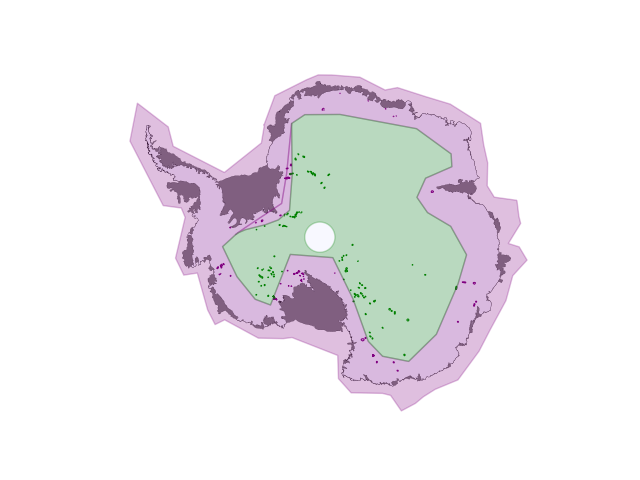

In [82]:
# Plotting map of lakes and their satellite 
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 15))
fig, ax0 = plt.subplots(1,1)

# Panel - continental plots ---------------------------------------------
moa_2014_coastline.plot(ax=ax0, color='gray', edgecolor='k', linewidth=0.1, zorder=1)
moa_2014_groundingline.plot(ax=ax0, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=1)
stationary_lakes_gdf[stationary_lakes_gdf['CS2_SARIn_time_period'].isin(['2010.5-2018.75', '2013.75-2018.75'])].boundary.plot(ax=ax0, edgecolor='purple', linestyle='solid', linewidth=0.75, zorder=2)
stationary_lakes_gdf[stationary_lakes_gdf['CS2_SARIn_time_period'] == '<NA>'].boundary.plot(ax=ax0, edgecolor='green', linestyle='solid', linewidth=0.75, zorder=2)

# Plot CryoSat-2 SARIn mode masks
gdf_SARIn_3_1.plot(ax=ax0, edgecolor='purple', facecolor='purple', alpha=0.25, zorder=3)
gdf_SARIn_3_1_3_6_diff.plot(ax=ax0, edgecolor='purple', facecolor='purple', alpha=0.25, zorder=3)
CS2_SARIn_union_polygon = unary_union([gdf_SARIn_3_1.geometry[0], gdf_SARIn_3_1_3_6_diff.geometry[0]])
CS2_SARIn_union_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [CS2_SARIn_union_polygon]}, crs='EPSG:3031')
CS2_SARIn_union_gdf = CS2_SARIn_union_gdf.to_crs(epsg=4326)

# Create ICESat-2 pole hole geodataframe
center_x, center_y = 0, 0  # Geographic South Pole
x, y = ll2ps(0, -88)
radius = y  # Radius from Geographic South Pole to -88 S latitude (ICESat-2's southernmost coverage)
IS2_pole_hole_poly = Point(center_x, center_y).buffer(radius)
IS2_pole_hole_gdf = gpd.GeoDataFrame(index=[0], geometry=[IS2_pole_hole_poly], crs="EPSG:3031")
IS2_pole_hole_gdf = IS2_pole_hole_gdf.to_crs(epsg=4326)

# IS2 interior to CS2 SARIn mode coverage
IS2_interior_poly = Polygon(shell=CS2_SARIn_union_gdf.geometry[0].interiors[0].coords, 
                            holes=[IS2_pole_hole_gdf.geometry[0].exterior.coords])
IS2_interior_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [IS2_interior_poly]}, crs='EPSG:4326')
IS2_interior_gdf = IS2_interior_gdf.to_crs(epsg=3031)
IS2_interior_gdf.plot(ax=ax0, edgecolor='green', facecolor='green', alpha=0.25, zorder=3)
ax0.axis('off')

plt.show()

In [96]:
dfs['subset_CS2_IS2_lakes_sum'].columns

Index(['midcyc_datetime', 'evolving_outlines_area (m^2)',
       'evolving_outlines_dh (m)', 'evolving_outlines_region_dh (m)',
       'evolving_outlines_dh_corr (m)', 'evolving_outlines_dvol_corr (m^3)',
       'stationary_outline_area (m^2)', 'stationary_outline_dh (m)',
       'stationary_outline_region_dh (m)', 'stationary_outline_dh_corr (m)',
       'stationary_outline_dvol_corr (m^3)', 'bias_area (m^2)',
       'bias_region_dh (m)', 'bias_outlines_dh_corr (m)',
       'bias_dvol_corr (m^3)'],
      dtype='object')

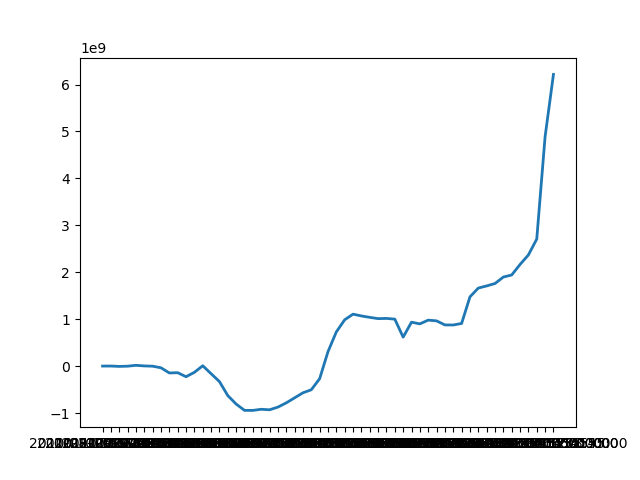

In [103]:
fig, ax = plt.subplots()

ax.plot(dfs['subset_CS2_IS2_lakes_sum']['midcyc_datetime'], 
        np.cumsum(dfs['subset_CS2_IS2_lakes_sum']['evolving_outlines_dvol_corr (m^3)']), 
        linewidth=2)

plt.show()

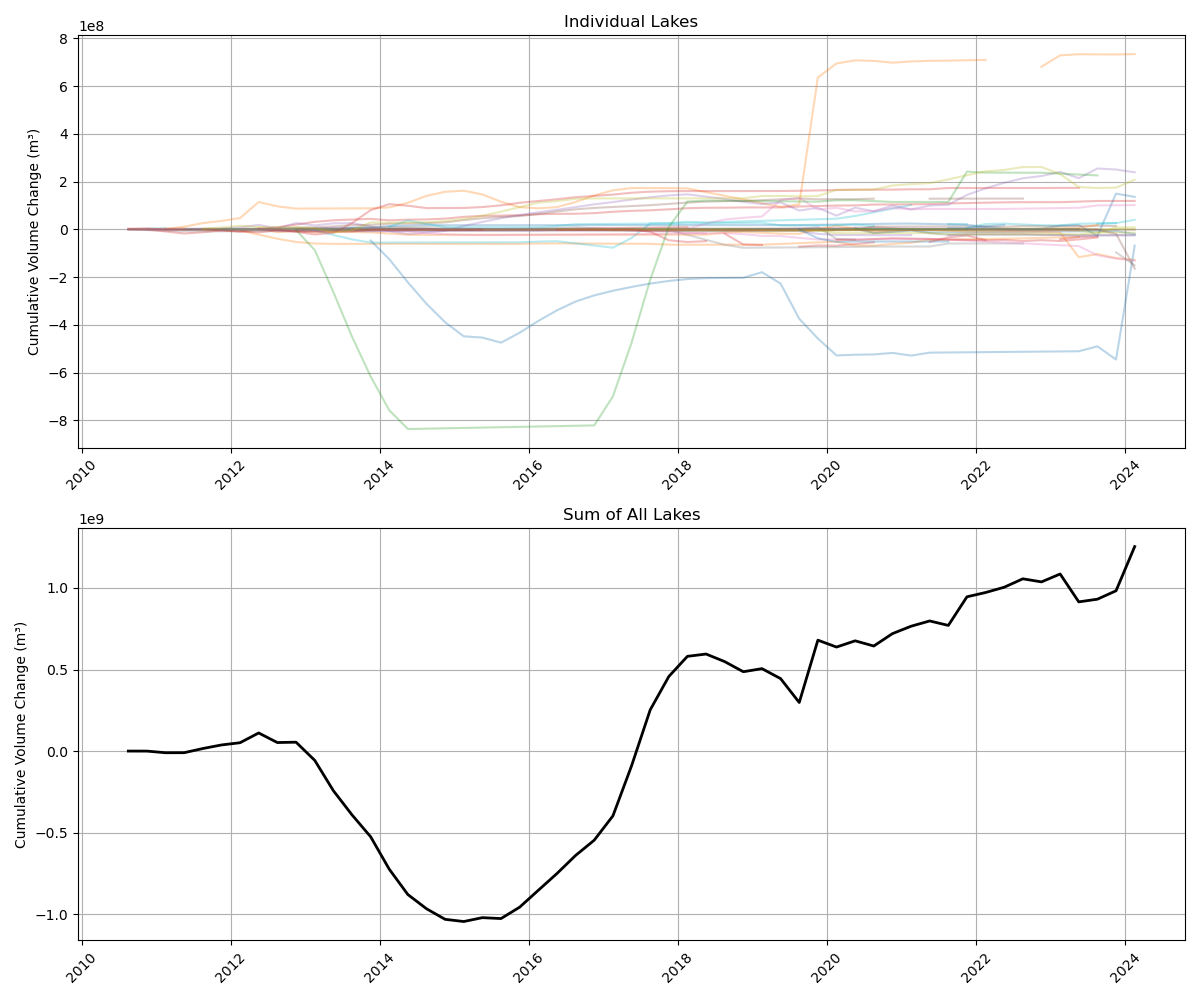

In [15]:
# Create dataframe combining evolving and stationary lake geometric calculations
directory = OUTPUT_DIR_GIT + '/geometric_calcs/compare_evolving_and_stationary_outlines/'

# Load individual lake data
dfs_subset_CS2_IS2_lakes = []

for file in os.listdir(directory):
    if file.endswith('.csv'):
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        lake_name = os.path.splitext(file)[0]
        lake_row = stationary_lakes_gdf[stationary_lakes_gdf['name'] == lake_name]
        
        if not lake_row.empty:
            time_period = lake_row['CS2_SARIn_time_period'].values[0]
            if time_period in ['2010.5-2018.75', '2013.75-2018.75']:
                dfs_subset_CS2_IS2_lakes.append(df)

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot individual lakes
for df in dfs_subset_CS2_IS2_lakes:
    ax1.plot(pd.to_datetime(df['midcyc_datetime']), 
            np.cumsum(df['evolving_outlines_dvol_corr (m^3)']), 
            alpha=0.3)

# Plot sum of all lakes
combined_df = pd.concat(dfs_subset_CS2_IS2_lakes)
summed_data = combined_df.groupby('midcyc_datetime')['evolving_outlines_dvol_corr (m^3)'].sum()
ax2.plot(pd.to_datetime(summed_data.index), 
        np.cumsum(summed_data.values), 
        linewidth=2, 
        color='black')

# Customize plots
for ax in [ax1, ax2]:
    ax.grid(True)
    ax.set_ylabel('Cumulative Volume Change (m³)')
    ax.tick_params(axis='x', rotation=45)

ax1.set_title('Individual Lakes')
ax2.set_title('Sum of All Lakes')

plt.tight_layout()
plt.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
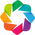

:HoloMap   [lake_name]
   :Curve   [datetime]   (cumsum_vol)

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import holoviews as hv
hv.extension('bokeh')

# Load data
dfs_subset_CS2_IS2_lakes = []
lake_names = []

for file in os.listdir(directory):
    if file.endswith('.csv'):
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        lake_name = os.path.splitext(file)[0]
        lake_row = stationary_lakes_gdf[stationary_lakes_gdf['name'] == lake_name]
        
        if not lake_row.empty:
            time_period = lake_row['CS2_SARIn_time_period'].values[0]
            if not pd.isna(time_period) and time_period != '<NA>' and time_period in ['2010.5-2018.75', '2013.75-2018.75']:
                df['lake_name'] = lake_name
                df['datetime'] = pd.to_datetime(df['midcyc_datetime'])
                df['cumsum_vol'] = np.cumsum(df['evolving_outlines_dvol_corr (m^3)'])
                dfs_subset_CS2_IS2_lakes.append(df)
                lake_names.append(lake_name)

combined_df = pd.concat(dfs_subset_CS2_IS2_lakes)

# Create interactive plot
curves = hv.Dataset(combined_df, kdims=['datetime', 'cumsum_vol', 'lake_name'])
plot = curves.to(hv.Curve, 'datetime', 'cumsum_vol', groupby='lake_name')

# Customize plot
plot.opts(
    width=800,
    height=400,
    line_alpha=0.6,
    tools=['hover'],
    title='Lake Volume Changes Over Time',
    xlabel='Date',
    ylabel='Cumulative Volume Change (m³)',
    hover_line_alpha=1.0,
    hover_line_color='red',
    show_grid=True
)
    
    # return plot

# Example usage:
# plot = create_interactive_plot(directory, stationary_lakes_gdf)
# hv.save(plot, 'interactive_plot.html')